# Data Importing, Cleaning and Imputation

In [1]:
"""
Importing modules here
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import missingno as msno

from scipy.stats import kurtosis, skew

In [2]:
competition_clubs = pd.read_csv('../data/2024_12_20_16_12/competition_clubs.csv')
player_info = pd.read_csv('../data/2024_12_20_16_12/player_info.csv')
player_jersey_numbers = pd.read_csv('../data/2024_12_20_16_12/player_jersey_numbers.csv')
player_market_values = pd.read_csv('../data/2024_12_20_16_12/player_market_values.csv')
player_stats = pd.read_csv('../data/2024_12_20_16_12/player_stats.csv')

In [3]:
"""
Making youth team corrections in competition_clubs
"""
youth_team_corrections = {
    # England
    1010: (37993, "Watford FC U21"),
    2288: (33616, "Swansea City U21"),
    1039: (33727, "Queens Park Rangers U21"),
    1031: (92433, "Luton Town U21"),
    # Spain
    621: (6688, "Bilbao Athletic"),
    366: (7078, "Real Valladolid Promesas"),
    714: (10773, "RCD Espanyol B"),
    16795: (21550, "Recreativo Granada"),
    2448: (12331, "Sporting Atlético"),
    # Italy
    1025: (14848, "Bologna Primavera"),
    4102: (27531, "Carpi Primavera"),
    5: (10958, "AC Milan Primavera"),
    458: (11493, "Palermo Primavera"),
    800: (11998, "Atalanta Primavera"),
    862: (14845, "Chievo Primavera"),
    2722: (22276, "SPAL Primavera"),
    19: (14829, "Brescia Primavera"),
    1429: (20106, "Cesena Primavera"),
    # Germany
    533: (983, "TSG 1899 Hoffenheim II"),
    # France
    583: (6326, "Paris Saint-Germain U19"),
    995: (10850, "FC Nantes B"),
    1159: (10840, "AS Nancy-Lorraine B"),
    3558: (49984, "GFC Ajaccio U19"),
    14171: (28560, "Thonon Évian Grand Genève FC B")
}

other_team_corrections = {
    92878: 418, # Real Madrid C -> Real Madrid
    41107: 5, # Milan Futuro -> AC Milan
    41110: 800, # Atalanta U23 -> Atalanta
    41101: 506, # Juventus Next Gen -> Juventus
    7813: 1041, # Olympique Lyon U19 -> Olympique Lyon
    43570: 583, # PSG Espoirs -> PSG
    10851: 995, # FC Nantes U19 -> FC Nantes
    14626: 2288, # Swansea City U18 -> Swansea City
    14619: 1031, # Luton Town U18 -> Luton Town
    12805: 1039, # QPR U18 -> QPR
    10732: 1010, # Watford FC U18 -> Watford FC
    10841: 995, # AS Nancy U19 -> AS Nancy
}

def apply_corrections(row, corrections):
    club_id = row["club_id"]
    if club_id in corrections:
        row["youth_team_id"], row["youth_team_name"] = corrections[club_id]
    return row

In [4]:
competition_clubs = competition_clubs.apply(apply_corrections,
                                            axis=1,
                                            corrections=youth_team_corrections)
competition_clubs['youth_team_id'] = competition_clubs['youth_team_id'].astype('Int64')

In [5]:
"""
Fixing situation where young players are registered for their club's
youth teams despite possibly making appearances for the senior team
which may affect market value EDA.
"""
mapping_df = competition_clubs[['youth_team_id', 'club_id', 'club_name']]

merged_df = player_market_values.merge(
    mapping_df,
    left_on='club_id',
    right_on='youth_team_id',
    how='left',
    suffixes=('', '_mapped')
)

# Update club_id and club_name only where there is a match
merged_df['club_id'] = merged_df['club_id_mapped'].fillna(merged_df['club_id']).astype('Int64')
merged_df['club_name'] = merged_df['club_name_mapped'].fillna(merged_df['club_name'])
edited_player_market_values = merged_df.drop(columns=['club_id_mapped', 'club_name_mapped', 'youth_team_id'])

# Verifying change
print("[BEFORE] # of observations for Real Madrid & Real Madrid Castilla: ",
      len(player_market_values[player_market_values['club_id'] == 418]),
      ", ",
      len(player_market_values[player_market_values['club_id'] == 6767]))
print("[AFTER] # of observations for Real Madrid & Real Madrid Castilla: ",
      len(edited_player_market_values[edited_player_market_values['club_id'] == 418]),
      ", ",
      len(edited_player_market_values[edited_player_market_values['club_id'] == 6767]))

# Also updating instances of alternate teams using `other_team_corrections` dictionary (not changing club_name however)
edited_player_market_values['club_id'] = edited_player_market_values['club_id'].replace(other_team_corrections)

[BEFORE] # of observations for Real Madrid & Real Madrid Castilla:  1027 ,  586
[AFTER] # of observations for Real Madrid & Real Madrid Castilla:  1613 ,  0


In [6]:
"""
Fixing competition_clubs so it doesn't have an issue when merging
"""
display(competition_clubs.head())

# Step 1: Split the 'season_id(s)' column and explode it into individual rows
expanded_competition_clubs = competition_clubs.copy()
expanded_competition_clubs['season_id(s)'] = expanded_competition_clubs['season_id(s)'].astype(str).str.split(',')  # Split the string into lists
expanded_competition_clubs = expanded_competition_clubs.explode('season_id(s)')

# Step 2: Convert season_id(s) to the desired format (e.g., 2024 -> '24/25')
expanded_competition_clubs['season_id(s)'] = expanded_competition_clubs['season_id(s)'].astype(int)  # Ensure it's numeric for manipulation
expanded_competition_clubs['season_id(s)'] = expanded_competition_clubs['season_id(s)'].apply(lambda x: f"{str(x)[-2:]}/{str(x + 1)[-2:]}")

# Step 3: Rename the column to 'season'
expanded_competition_clubs.rename(columns={'season_id(s)': 'season'}, inplace=True)
expanded_competition_clubs.reset_index(drop=True, inplace=True)

display(expanded_competition_clubs.head(11))

,competition_id,season_id(s),club_id,club_name,youth_team_id,youth_team_name
0,ES1,"2023,2022,2021,2020,2019,2018,2017,2016,2015,2014",131,FC Barcelona,2464,FC Barcelona Atlètic
1,ES1,"2023,2021,2020,2019,2016,2015,2014",16795,Granada CF,21550,Recreativo Granada
2,ES1,"2023,2022,2021,2020,2019,2018,2017,2016,2015,2014",368,Sevilla FC,8519,Sevilla Atlético
3,ES1,"2023,2022,2021,2020,2019,2018,2017,2016,2015,2014",1050,Villarreal CF,11972,Villarreal CF B
4,ES1,"2023,2022,2021,2020,2019,2018,2017,2016,2015,2014",418,Real Madrid,6767,Real Madrid Castilla


,competition_id,season,club_id,club_name,youth_team_id,youth_team_name
0,ES1,23/24,131,FC Barcelona,2464,FC Barcelona Atlètic
1,ES1,22/23,131,FC Barcelona,2464,FC Barcelona Atlètic
2,ES1,21/22,131,FC Barcelona,2464,FC Barcelona Atlètic
3,ES1,20/21,131,FC Barcelona,2464,FC Barcelona Atlètic
4,ES1,19/20,131,FC Barcelona,2464,FC Barcelona Atlètic
5,ES1,18/19,131,FC Barcelona,2464,FC Barcelona Atlètic
6,ES1,17/18,131,FC Barcelona,2464,FC Barcelona Atlètic
7,ES1,16/17,131,FC Barcelona,2464,FC Barcelona Atlètic
8,ES1,15/16,131,FC Barcelona,2464,FC Barcelona Atlètic
9,ES1,14/15,131,FC Barcelona,2464,FC Barcelona Atlètic


In [7]:
"""
Doing the data merges here to get the full dataset with I'll be working with
"""
print("Table for expanded_competition_clubs:")
display(expanded_competition_clubs.head())
print("Table for player_info:")
display(player_info.head())
print("Table for player_jersey_numbers:")
display(player_jersey_numbers.head())
print("Table for edited_player_market_values:")
display(edited_player_market_values.head())
print("Table for player_stats:")
display(player_stats.head())

# TEMP NOTE: null values pertaining to the top 5 leagues 
# here are largely of players who didn't make an appearance
# but still had a registered jersey number
print()
print("Table built so far:")
player_jnumbs_filtered = player_jersey_numbers.merge(
    expanded_competition_clubs,
    on=['season', 'club_id'],
    how='inner'
)
player_jnumbs_filtered.drop(['youth_team_id', 'youth_team_name'], axis=1, inplace=True)

player_jnumbs_marktvals = player_jnumbs_filtered.merge(
    edited_player_market_values,
    on=['player_id', 'season', 'club_id'],
    how='left',
    suffixes=['', '_drop']
)
player_jnumbs_marktvals.drop(['club_name_drop'], axis=1, inplace=True)

player_jnumbs_marktvals_stats = player_jnumbs_marktvals.merge(
    player_stats,
    on=['player_id', 'season', 'competition_id', 'club_id'],
    how='left'
)

players_df = player_jnumbs_marktvals_stats.merge(
    player_info,
    on=['player_id'],
    how='left'
)

display(players_df.head())

Table for expanded_competition_clubs:


,competition_id,season,club_id,club_name,youth_team_id,youth_team_name
0,ES1,23/24,131,FC Barcelona,2464,FC Barcelona Atlètic
1,ES1,22/23,131,FC Barcelona,2464,FC Barcelona Atlètic
2,ES1,21/22,131,FC Barcelona,2464,FC Barcelona Atlètic
3,ES1,20/21,131,FC Barcelona,2464,FC Barcelona Atlètic
4,ES1,19/20,131,FC Barcelona,2464,FC Barcelona Atlètic


Table for player_info:


,player_id,player_name,image_url,date_of_birth,height,primary_citizenship,secondary_citizenship,main_position,other_positions,preferred_foot,outfitter
0,944847,Edvin Bongemba,NaN,"Jan 14, 2004","1,88m",France,DR Congo,Attacking Midfield,"Left Winger, Central Midfield",right,NaN
1,792380,Aleksandar Pavlovic,https://img.a.transfermarkt.technology/portrai...,"May 3, 2004","1,88m",Germany,Serbia,Defensive Midfield,Central Midfield,both,Nike
2,804548,Baptiste Mouazan,https://img.a.transfermarkt.technology/portrai...,"Sep 27, 2001","1,74m",France,NaN,Central Midfield,Attacking Midfield,right,NaN
3,430503,Jacopo Da Riva,https://img.a.transfermarkt.technology/portrai...,"Oct 27, 2000","1,87m",Italy,NaN,Central Midfield,"Defensive Midfield, Attacking Midfield",both,NaN
4,516407,Bojan Radulović,https://img.a.transfermarkt.technology/portrai...,"Dec 29, 1999","1,92m",Serbia,Spain,Centre-Forward,NaN,right,adidas


Table for player_jersey_numbers:


,player_id,season,club_id,jersey_number
0,944847,23/24,6572,8
1,944847,23/24,6572,11
2,944847,23/24,6572,13
3,944847,23/24,6572,14
4,944847,22/23,969,32


Table for edited_player_market_values:


,player_id,date,club_id,club_name,value,season
0,944847,"Jun 27, 2023",969,Montpellier HSC B,€50k,22/23
1,944847,"Jun 28, 2024",969,Montpellier HSC B,NaN,23/24
2,792380,"Aug 1, 2023",27,FC Bayern Munich II,€200k,23/24
3,792380,"Dec 14, 2023",27,Bayern Munich,€2.00m,23/24
4,792380,"Mar 27, 2024",27,Bayern Munich,€25.00m,23/24


Table for player_stats:


,player_id,competition_id,competition_name,season,club_id,appearances,minutes_played,goals,assists,yellow_cards,red_cards
0,944847,C3CM,National 3 - Grp. A,23/24,6572,22.0,1.423',6.0,NaN,4.0,NaN
1,944847,F19F,National U19 - Tour final,22/23,10852,1.0,12',NaN,NaN,NaN,NaN
2,944847,C3OC,N3 - Occitanie,22/23,6572,16.0,1.192',1.0,1.0,2.0,NaN
3,944847,FR1,Ligue 1,22/23,969,NaN,NaN,NaN,NaN,NaN,NaN
4,944847,F19D,National U19 - Grp. D,22/23,10852,2.0,166',NaN,NaN,2.0,NaN



Table built so far:


,player_id,season,club_id,jersey_number,competition_id,club_name,date,value,competition_name,appearances,...,player_name,image_url,date_of_birth,height,primary_citizenship,secondary_citizenship,main_position,other_positions,preferred_foot,outfitter
0,944847,22/23,969,32,FR1,Montpellier HSC,"Jun 27, 2023",€50k,Ligue 1,NaN,...,Edvin Bongemba,NaN,"Jan 14, 2004","1,88m",France,DR Congo,Attacking Midfield,"Left Winger, Central Midfield",right,NaN
1,944847,22/23,969,34,FR1,Montpellier HSC,"Jun 27, 2023",€50k,Ligue 1,NaN,...,Edvin Bongemba,NaN,"Jan 14, 2004","1,88m",France,DR Congo,Attacking Midfield,"Left Winger, Central Midfield",right,NaN
2,792380,23/24,27,45,L1,Bayern Munich,"Aug 1, 2023",€200k,Bundesliga,19.0,...,Aleksandar Pavlovic,https://img.a.transfermarkt.technology/portrai...,"May 3, 2004","1,88m",Germany,Serbia,Defensive Midfield,Central Midfield,both,Nike
3,792380,23/24,27,45,L1,Bayern Munich,"Dec 14, 2023",€2.00m,Bundesliga,19.0,...,Aleksandar Pavlovic,https://img.a.transfermarkt.technology/portrai...,"May 3, 2004","1,88m",Germany,Serbia,Defensive Midfield,Central Midfield,both,Nike
4,792380,23/24,27,45,L1,Bayern Munich,"Mar 27, 2024",€25.00m,Bundesliga,19.0,...,Aleksandar Pavlovic,https://img.a.transfermarkt.technology/portrai...,"May 3, 2004","1,88m",Germany,Serbia,Defensive Midfield,Central Midfield,both,Nike


In [8]:
"""
NOTE ABOUT NULL VALUES:
- `competition_name`: null values occur due to pulling it from player_stats,
  so players who technically had a registered jersey number for their team
  but didn't appear in the league competition.

OTHER NOTES:
- Since dataframe has time-series data, the player stats refer to the
  player's season stats and NOT their stats upto `date`.
"""
print(players_df.info())
print()
print(players_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85804 entries, 0 to 85803
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   player_id              85804 non-null  int64  
 1   season                 85804 non-null  object 
 2   club_id                85804 non-null  int64  
 3   jersey_number          85804 non-null  int64  
 4   competition_id         85804 non-null  object 
 5   club_name              85804 non-null  object 
 6   date                   81612 non-null  object 
 7   value                  81442 non-null  object 
 8   competition_name       81882 non-null  object 
 9   appearances            72731 non-null  float64
 10  minutes_played         72731 non-null  object 
 11  goals                  37508 non-null  float64
 12  assists                37903 non-null  float64
 13  yellow_cards           55470 non-null  float64
 14  red_cards              5483 non-null   float64
 15  pl

In [9]:
"""
Cleaning up the dataframe and re-organizing it
"""

clean_players_df = players_df.copy()

# Renaming columns
clean_players_df.rename(columns={
                            'date': 'date_assessed',
                            'value': 'market_value_euros',
                            'height': 'height_meters'
                        },
                        inplace=True)

# Adjusting market_value_euros, height_meters, minutes_played
clean_players_df['market_value_euros'] = (
    clean_players_df['market_value_euros']
    .str.replace('€', '', regex=False)
    .str.replace('m', 'e6', regex=False)
    .str.replace('k', 'e3', regex=False)
    .apply(pd.to_numeric, errors='coerce')
    .astype('Int64')
)
clean_players_df['height_meters'] = (
    clean_players_df['height_meters']
    .str.replace(',', '.', regex=False)
    .str.replace('m', '', regex=False)
    .astype(float)
)
clean_players_df['minutes_played'] = clean_players_df['minutes_played'].str.replace("[.']", "", regex=True)

# Updating datatypes
stats_columns = ['appearances', 'minutes_played', 'goals', 'assists', 'yellow_cards', 'red_cards'] # should all be int64 dtypes
categorical_columns = ['season', 'competition_id', 'competition_name', 'club_name', 'main_position',
                       'primary_citizenship', 'secondary_citizenship', 'preferred_foot', 'outfitter'] # leaving out secondary positions for right now
list_of_seasons = ['14/15', '15/16', '16/17', '17/18', '18/19',
                   '19/20', '20/21', '21/22', '22/23', '23/24'] # Need to edit depending on number of seasons

clean_players_df[['date_of_birth', 'date_assessed']] = clean_players_df[['date_of_birth', 'date_assessed']].apply(pd.to_datetime, errors='coerce')
for col in stats_columns:
    clean_players_df[col] = clean_players_df[col].astype('Int64')
for col in categorical_columns:
    clean_players_df[col] = clean_players_df[col].astype('category')

clean_players_df['season'] = clean_players_df['season'].cat.reorder_categories(
    new_categories=list_of_seasons,
    ordered=True
)

# Creating an age when assessed market_value was assessed
clean_players_df['age_when_assessed'] = ((clean_players_df['date_assessed'] - clean_players_df['date_of_birth']).dt.days // 365).astype('Int64')

# Reorder the columns
column_order = [
    'season', 'competition_id', 'competition_name', 'club_id', 'club_name',
    'player_id', 'player_name', 'date_of_birth', 'height_meters', 'primary_citizenship', 'secondary_citizenship',
    'main_position', 'other_positions', 'preferred_foot', 'outfitter', 'jersey_number',
    'appearances', 'minutes_played', 'goals', 'assists', 'yellow_cards', 'red_cards',
    'market_value_euros', 'date_assessed', 'age_when_assessed', 'image_url'
]
clean_players_df = clean_players_df[column_order]

In [10]:
"""
Dealing with null values
"""

# Filling null values for player stats with 0
clean_players_df[stats_columns] = clean_players_df[stats_columns].fillna(0)

# Filling null competition_name values based on competition_id
clean_players_df['competition_name'] = clean_players_df.groupby('competition_id', observed=False)['competition_name'].transform(
    lambda x: x.ffill().bfill()
)

# Dropping low null counts for EDA purposes
clean_players_df.dropna(
    subset=['main_position', 'date_of_birth', 'date_assessed', 'height_meters', 'preferred_foot'],
    inplace=True
)

# Function for imputing null market value based on other closest market value assessment by date
def fill_missing_market_values(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(by=['player_id', 'date_assessed'], inplace=True)
    missing_values_df = df[df['market_value_euros'].isna()]

    for player_id in missing_values_df['player_id'].unique():
        player_rows = df[df['player_id'] == player_id]

        missing_rows = player_rows[player_rows['market_value_euros'].isna()]

        for i, row in missing_rows.iterrows():
            date_assessed = row['date_assessed']
            prev_row = player_rows[(player_rows['date_assessed'] < date_assessed) & (player_rows['market_value_euros'].notna())] # Find the closest previous row (if any)
            next_row = player_rows[(player_rows['date_assessed'] > date_assessed) & (player_rows['market_value_euros'].notna())] # Find the closest next row (if any)

            if not prev_row.empty and not next_row.empty: # If both previous and next rows exist, choose the closer one
                prev_date = prev_row['date_assessed'].values[0]
                next_date = next_row['date_assessed'].values[0]

                if abs(date_assessed - prev_date) <= abs(next_date - date_assessed):
                    df.at[i, 'market_value_euros'] = prev_row['market_value_euros'].values[0]
                else:
                    df.at[i, 'market_value_euros'] = next_row['market_value_euros'].values[0]

            elif not prev_row.empty: # If only previous row exists, use it
                df.at[i, 'market_value_euros'] = prev_row['market_value_euros'].values[0]
            elif not next_row.empty: # If only next row exists, use it
                df.at[i, 'market_value_euros'] = next_row['market_value_euros'].values[0]
    return df

clean_players_df = fill_missing_market_values(clean_players_df)
clean_players_df.dropna(subset=['market_value_euros'], inplace=True) # dropping player's with only 1 MV observ. for season duration selected

In [11]:
print(clean_players_df.info())
print()
print(clean_players_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 80013 entries, 21133 to 17030
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   season                 80013 non-null  category      
 1   competition_id         80013 non-null  category      
 2   competition_name       80013 non-null  category      
 3   club_id                80013 non-null  int64         
 4   club_name              80013 non-null  category      
 5   player_id              80013 non-null  int64         
 6   player_name            80013 non-null  object        
 7   date_of_birth          80013 non-null  datetime64[ns]
 8   height_meters          80013 non-null  float64       
 9   primary_citizenship    80013 non-null  category      
 10  secondary_citizenship  31829 non-null  category      
 11  main_position          80013 non-null  category      
 12  other_positions        58385 non-null  object        
 13  pr

# EDA
---
## Univariate Analysis
1. `jersey_number`
    * What is it's distribution in general? By season & league?
3. `market_value_euros`
    * What is it's distribution in general? By season & league?
    * What is the general range of market values by league? (Boxplots w/ outliers)
    * How has average market values changed every season? How does it vary by league?
6. `age_when_assessed`
    * What is it's distribution in general? By season & league?
8. `primary_citizenship`
    * What are the counts of nationalities of players in this dataset?
    * What is the percent of native players in each league compared to foreigners? How does it change each season for each league?
11. `appearnaces`
    * How many different players made appearances in the Top 5 leagues every season?
12. `minutes_played`
    * What is the distribution of minutes played? (boxplot)
        * How does it vary by league & season?

## Bivariate Analysis
1. `jersey_number` & `main_position`
    * What are the most used numbers per position? How does it vary by season & league?
    * Is there any correlation?
2. `jersey_number` & `market_value_euros`
    * Is there any correlation? By leagues & season? (scatterplot)
        * Filtering for players who played significant minutes, how does the plot change?
    * Specifically looking into #10s, how have their average values changed every season?
3. `jersey_number` & `age_when_assessed`
    * Are certain jersey numbers associated with younger or older players?
        * Filtering by players who played significant minutes, is there any association?
5. `height_meters` & `main_position`
    * How does height vary amongst position & league
6. `market_value_euros` & `age_when_assessed`
    * How are average market values changing based on age ranges?
    * How does player value change with age? Does it peak at a specific range?
8. `minutes_played` & `age_when_assessed`
    * What are the trends in the number of minutes players are getting based on their age range? Are younger players getting more minutes now?

In [12]:
competition_colors = {
    'Premier League': '#38003c',
    'LaLiga': '#ffab44',
    'Serie A': '#0578FF',
    'Bundesliga': '#D10214',
    'Ligue 1': '#CDFB0A'
}

#### `jersey_number`

In [13]:
jerseynum_dist_viz_df = clean_players_df.drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id'],
                                                         keep='last').copy() # What jersey number the player wore for that season

##### Jersey Distribution by Competition & Season

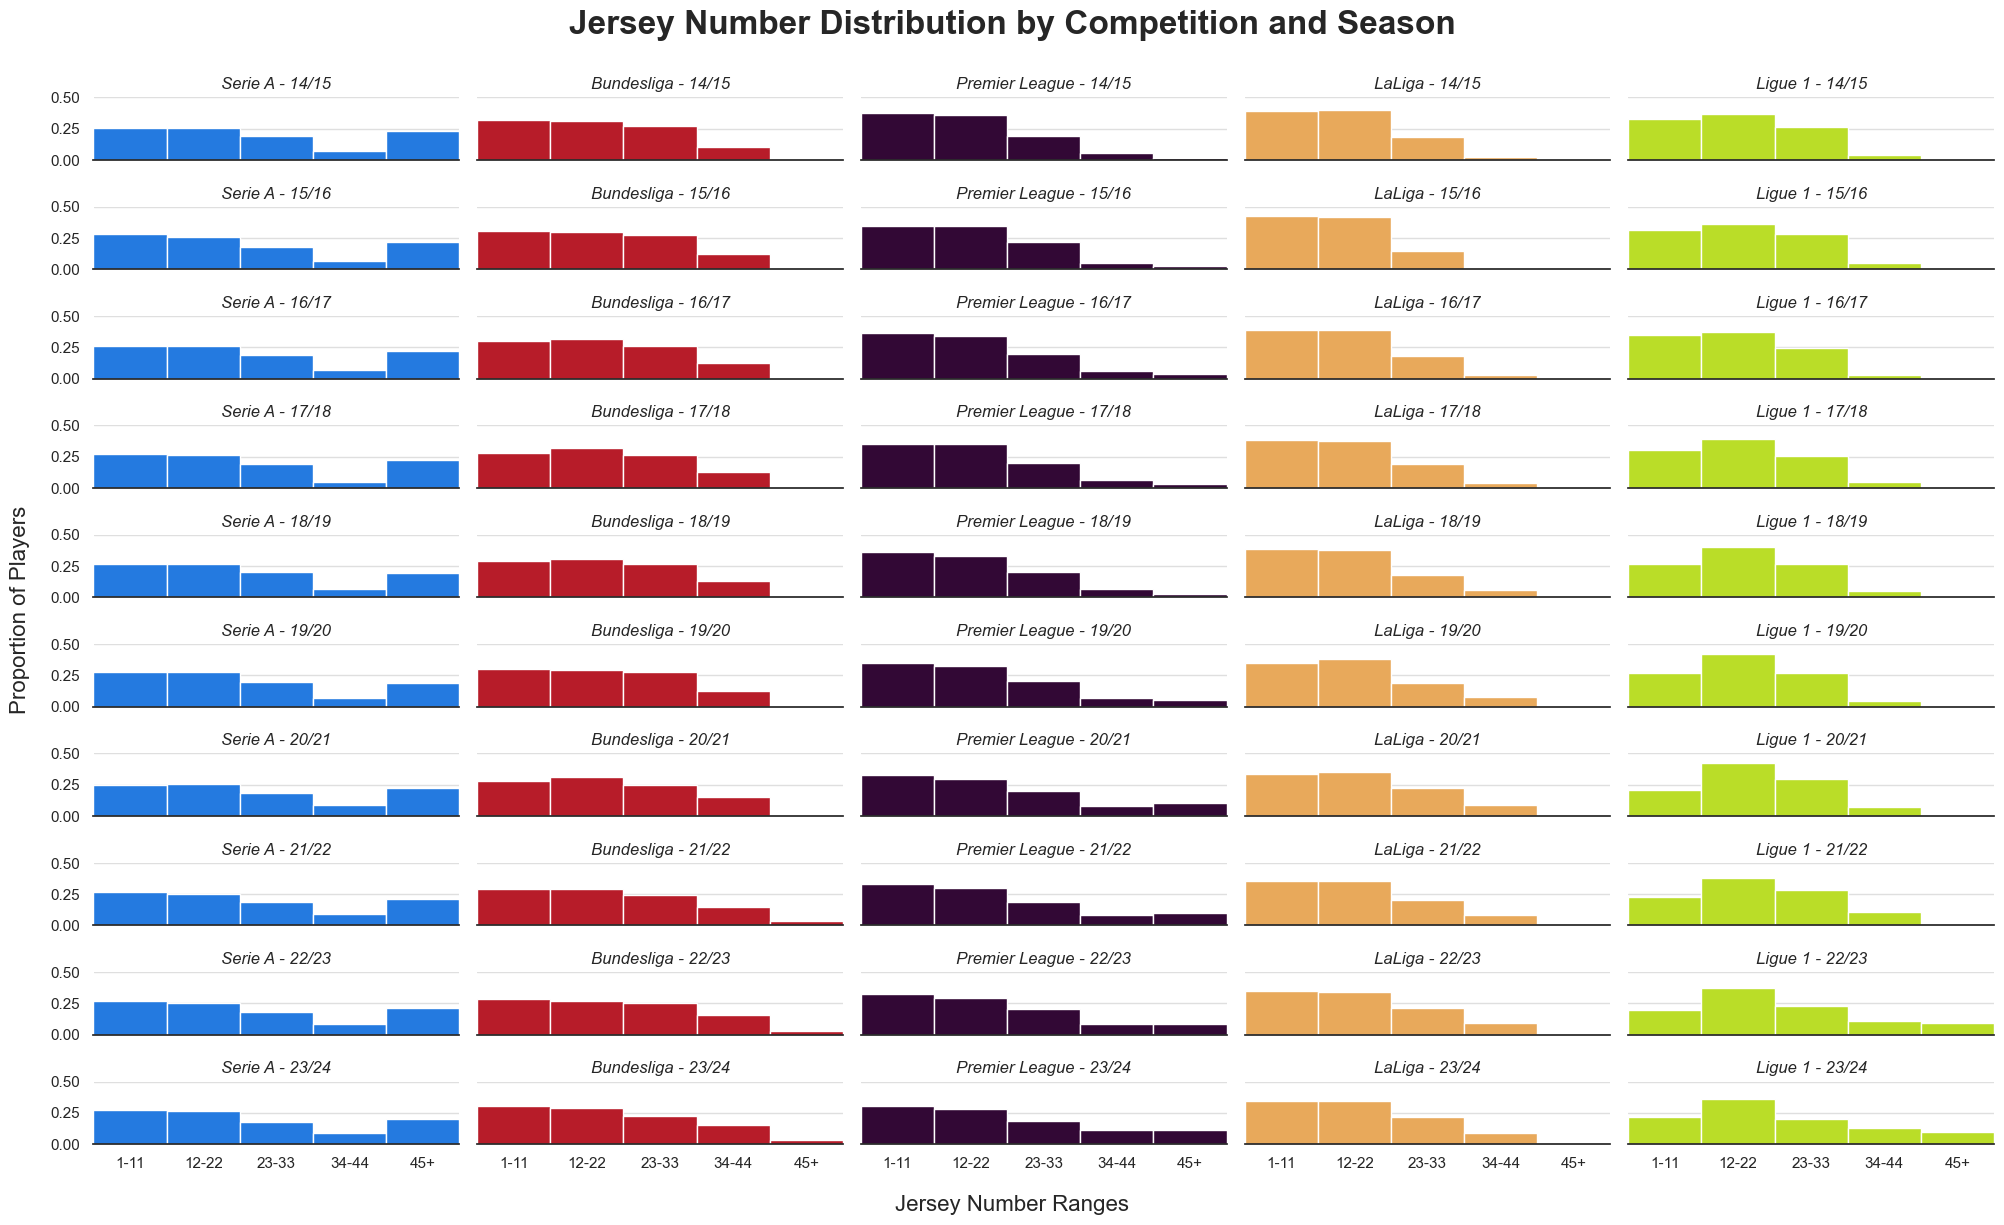

In [14]:
sns.set_theme(style="white", palette="muted")

# Creating lists:
seasons = jerseynum_dist_viz_df['season'].unique()
competitions = jerseynum_dist_viz_df['competition_name'].unique()

# custom_bins = [1, 12, 26, 51, np.inf]
# bin_labels = ['1-11', '12-25', '26-50', '51+']
custom_bins = [1, 12, 23, 34, 45, np.inf]
bin_labels = ['1-11', '12-22', '23-33', '34-44', '45+']
jerseynum_dist_viz_df['jersey_num_bins'] = pd.cut(
    jerseynum_dist_viz_df['jersey_number'], bins=custom_bins, labels=bin_labels
)

fig, axes = plt.subplots(len(seasons), len(competitions), figsize=(20, 12), sharex=True, sharey=True)
for i, season in enumerate(seasons):
    for j, competition in enumerate(competitions):
        ax = axes[i, j]

        season_competition_data = jerseynum_dist_viz_df[
            (jerseynum_dist_viz_df['season'] == season) &
            (jerseynum_dist_viz_df['competition_name'] == competition)
        ]

        proportions = season_competition_data['jersey_num_bins'].value_counts(normalize=True).sort_index()

        sns.barplot(
            x=proportions.index,
            y=proportions.values,
            legend=False,
            ax=ax,
            color=competition_colors.get(competition, '#000000'),
            gap=-0.25
        )

        ax.set_title(f"{competition} - {season}", fontstyle='italic')
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='y', linestyle='-', color='grey', alpha=0.25)
        ax.set_yticks([0.0, 0.25, 0.5])

fig.suptitle('Jersey Number Distribution by Competition and Season', fontsize=24, y=1, weight='bold')
fig.text(0.5, -0.001, 'Jersey Number Ranges', ha='center', fontsize=16)
fig.text(-0.001, 0.5, 'Proportion of Players', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.show()

__Notes:__
* _These bins are arbitrary and hold 11 jersey numbers each not following the typical numbering scheme for leagues_
1. Serie A seems to have consistently had numbers more than 45, while more recently the Premier League & Ligue 1 are also having jersey numbers that are more than 33.
2. Bundesliga & LaLiga seem to consistently have the same range where Bundesliga has a roughly equal divide for bins 1-11, 12-22, 23-33, while LaLiga consistently has most numbers in the 1-11 & 12-22 bins (likely due to their registration rules).

#### `market_value_euros`

In [15]:
markt_val_viz_df = clean_players_df.sort_values(by=['season', 'player_id', 'market_value_euros']).copy()
markt_val_viz_df.drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id'],
                                                         keep='last', # Keeping highest value for the player in that season
                                                         inplace=True)
markt_val_viz_df['log_market_value'] = np.log(markt_val_viz_df['market_value_euros']) # Adding log scale
display(markt_val_viz_df[markt_val_viz_df['player_name'] == "Bukayo Saka"].style.format({"market_value_euros": "{:,.0f}"}))

,season,competition_id,competition_name,club_id,club_name,player_id,player_name,date_of_birth,height_meters,primary_citizenship,secondary_citizenship,main_position,other_positions,preferred_foot,outfitter,jersey_number,appearances,minutes_played,goals,assists,yellow_cards,red_cards,market_value_euros,date_assessed,age_when_assessed,image_url,log_market_value
70575,19/20,GB1,Premier League,11,Arsenal FC,433177,Bukayo Saka,2001-09-05 00:00:00,1.780000,England,Nigeria,Right Winger,"Left Winger, Right Midfield",left,New Balance,77,26,1753,1,5,6,0,"22,000,000",2020-03-09 00:00:00,18,https://img.a.transfermarkt.technology/portrait/header/433177-1684155052.jpg?lm=1,16.906553
70572,20/21,GB1,Premier League,11,Arsenal FC,433177,Bukayo Saka,2001-09-05 00:00:00,1.780000,England,Nigeria,Right Winger,"Left Winger, Right Midfield",left,New Balance,7,32,2561,5,3,1,0,"65,000,000",2021-05-28 00:00:00,19,https://img.a.transfermarkt.technology/portrait/header/433177-1684155052.jpg?lm=1,17.989898
70568,21/22,GB1,Premier League,11,Arsenal FC,433177,Bukayo Saka,2001-09-05 00:00:00,1.780000,England,Nigeria,Right Winger,"Left Winger, Right Midfield",left,New Balance,7,38,2994,11,7,6,0,"65,000,000",2022-06-15 00:00:00,20,https://img.a.transfermarkt.technology/portrait/header/433177-1684155052.jpg?lm=1,17.989898
70566,22/23,GB1,Premier League,11,Arsenal FC,433177,Bukayo Saka,2001-09-05 00:00:00,1.780000,England,Nigeria,Right Winger,"Left Winger, Right Midfield",left,New Balance,7,38,3194,14,11,6,0,"120,000,000",2023-06-20 00:00:00,21,https://img.a.transfermarkt.technology/portrait/header/433177-1684155052.jpg?lm=1,18.603002
70561,23/24,GB1,Premier League,11,Arsenal FC,433177,Bukayo Saka,2001-09-05 00:00:00,1.780000,England,Nigeria,Right Winger,"Left Winger, Right Midfield",left,New Balance,7,35,2936,16,9,4,0,"140,000,000",2024-05-27 00:00:00,22,https://img.a.transfermarkt.technology/portrait/header/433177-1684155052.jpg?lm=1,18.757153


##### General Market Value Distribution

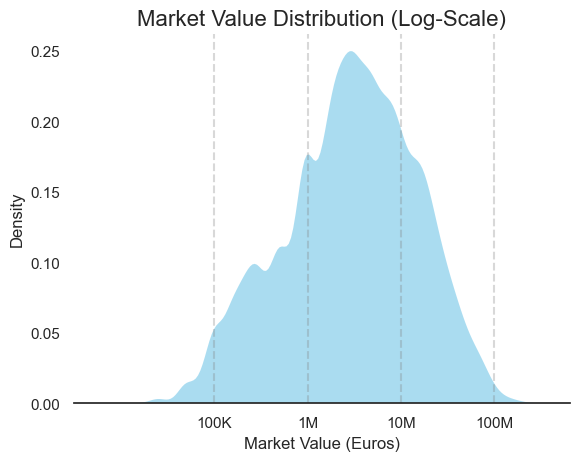

In [16]:
sns.set_theme(style="white", palette="muted")

# Plot the KDE with the logarithmic scale for better interpretability
ax = sns.kdeplot(
    data=markt_val_viz_df,
    x='log_market_value',
    fill=True,
    color='skyblue',  # You can change the color for better aesthetics
    linewidth=2,  # Thicker line for better visibility
    alpha=0.7,  # More solid fill
    edgecolor='none'  # Remove outline of the fill
)

# Customize the plot for better readability and style
plt.title('Market Value Distribution (Log-Scale)', fontsize=16)
plt.xlabel('Market Value (Euros)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Set custom ticks for the x-axis at (100K, 1M, 10M, 100M)
x_ticks = [np.log(100000), np.log(1000000), np.log(10000000), np.log(100000000)]
x_tick_labels = ['100K', '1M', '10M', '100M']
plt.xticks(x_ticks, x_tick_labels)

sns.despine(ax=ax, top=True, right=True, left=True)
plt.grid(False)  # Remove default grid
for tick in x_ticks:
    plt.axvline(x=tick, color='gray', linestyle='--', alpha=0.3)  # Vertical dashed lines

# Show the plot
plt.show()

##### Market Value Distribution by Competition & Season

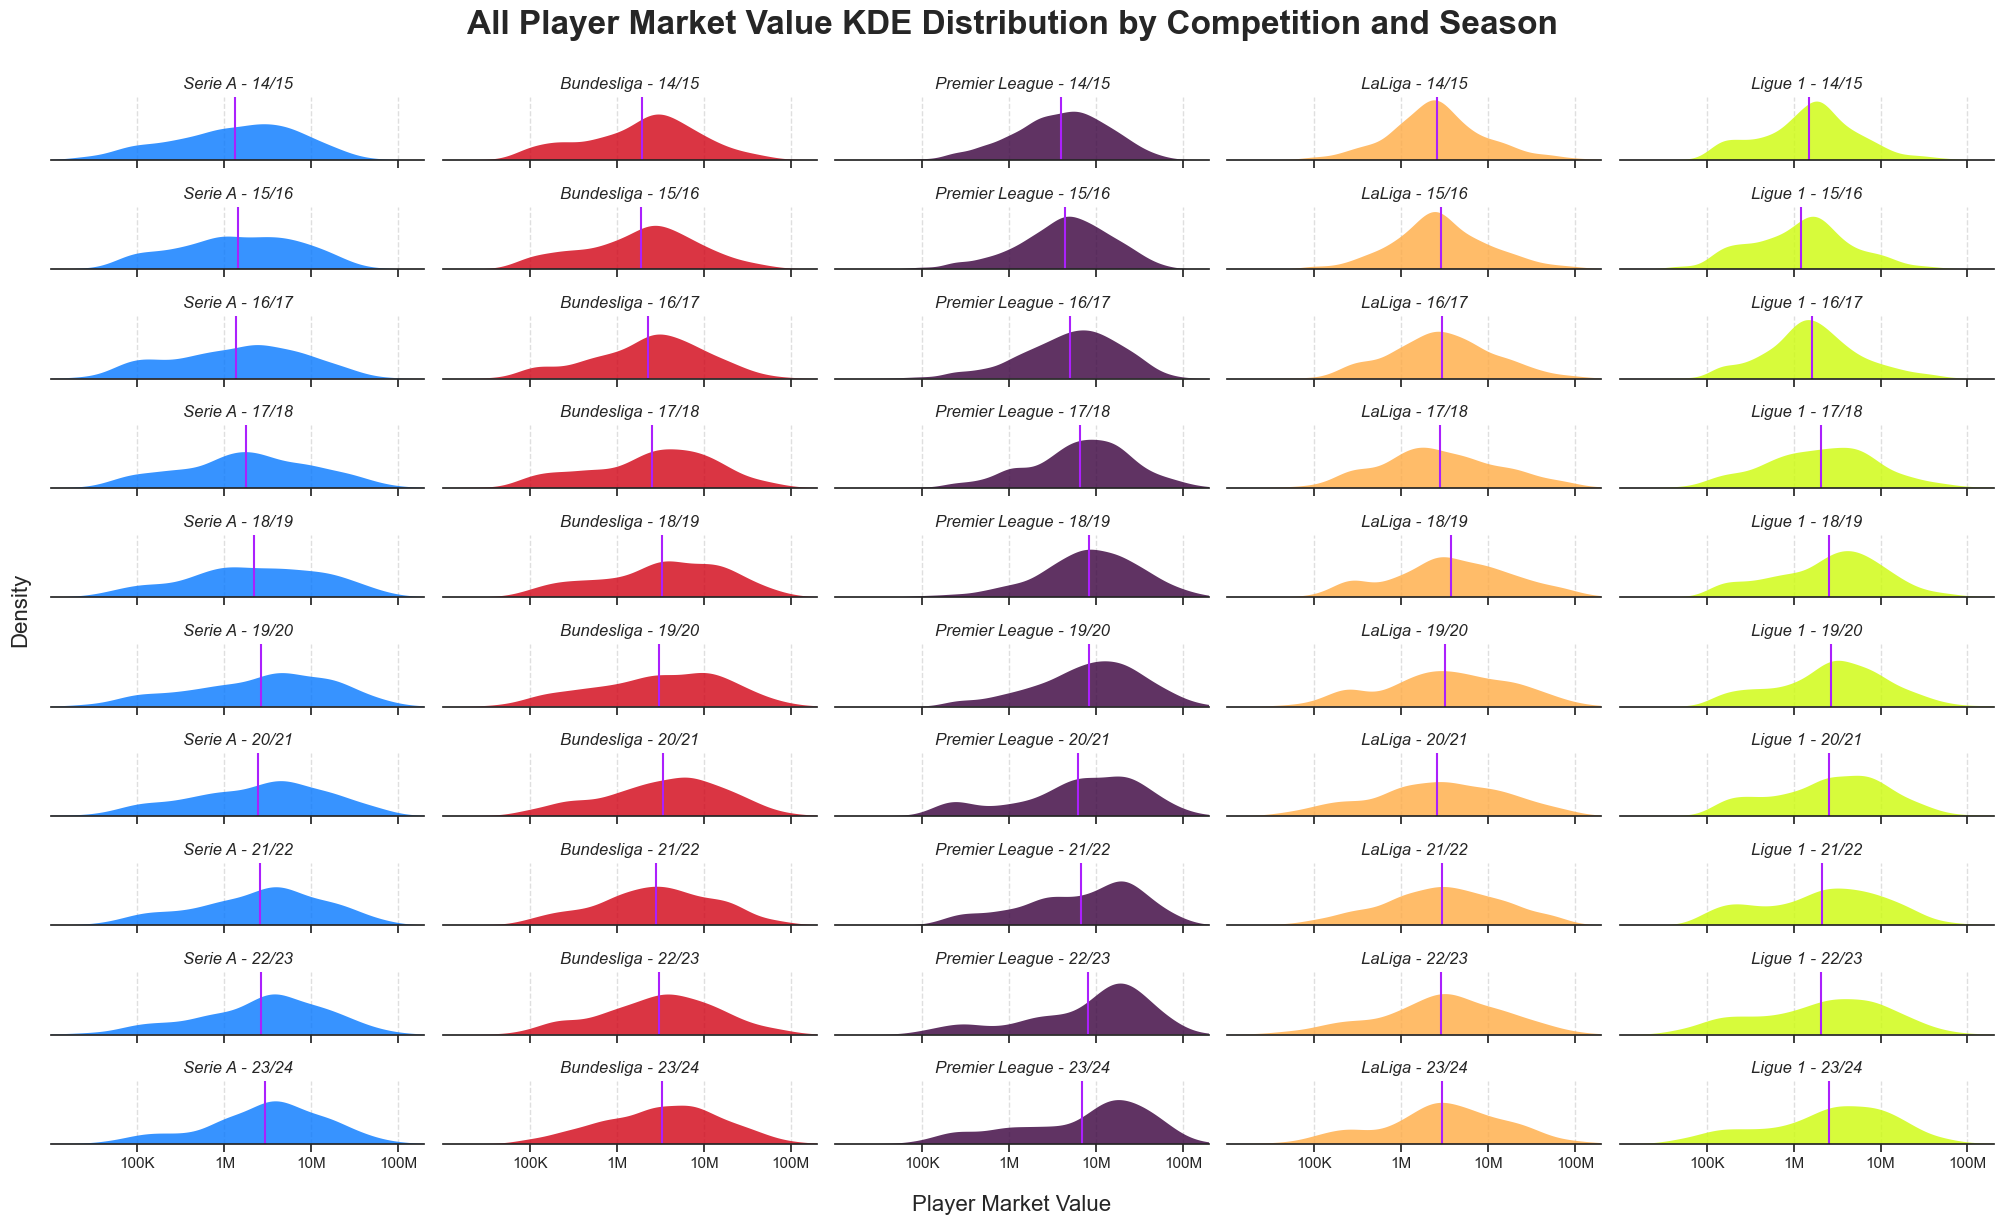

In [17]:
sns.set_theme(style="white", palette="muted", rc={'xtick.bottom': True})

markt_val_viz_df['log_market_value'] = np.log(markt_val_viz_df['market_value_euros'])

seasons = markt_val_viz_df['season'].unique()
competitions = markt_val_viz_df['competition_name'].unique()
min_log_val = markt_val_viz_df['log_market_value'].min()
max_log_val = markt_val_viz_df['log_market_value'].max()

fig, axes = plt.subplots(len(seasons), len(competitions), figsize=(20, 12), sharex=True, sharey=True)
for i, season in enumerate(seasons):
    for j, competition in enumerate(competitions):
        ax = axes[i, j]

        season_competition_data = markt_val_viz_df[
            (markt_val_viz_df['season'] == season) & 
            (markt_val_viz_df['competition_name'] == competition)
        ]

        sns.kdeplot(x=season_competition_data['log_market_value'],
                    fill=True,
                    color=competition_colors.get(competition, '#000000'),
                    alpha=0.8,
                    edgecolor='none',
                    ax=ax)
        
        mean_value = season_competition_data['log_market_value'].mean()
        ax.axvline(mean_value, color='#ab20fd', linestyle='-', label=f'Mean: {mean_value:.2f}')

        x_ticks = [np.log(100000), np.log(1000000), np.log(10000000), np.log(100000000)]
        x_tick_labels = ['100K', '1M', '10M', '100M']
        ax.set_xticks(x_ticks, x_tick_labels)
        ax.set_xlim(min_log_val, max_log_val)
        ax.grid(axis='x', linestyle='--', color='grey', alpha=0.25)

        ax.set_yticks([])
        
        ax.set_title(f"{competition} - {season}", fontstyle='italic')
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

fig.suptitle('All Player Market Value KDE Distribution by Competition and Season', fontsize=24, y=1, weight='bold')
fig.text(0.5, -0.001, 'Player Market Value', ha='center', fontsize=16)
fig.text(-0.001, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.show()

__Notes:__
* _This viz shows market values for every player registered for that competition & season. Purple line indicates mean log market value_
1. What is clear is that there is persistent left skew for market values for the Premier League, while they also have consistently the highest average market value. All the other leagues largely seem to follow a more 'normal' logarithmic scale with some left skew.
* Let's filter for players who have actually played a couple of games in the competition to see real differences between competition & seasons.

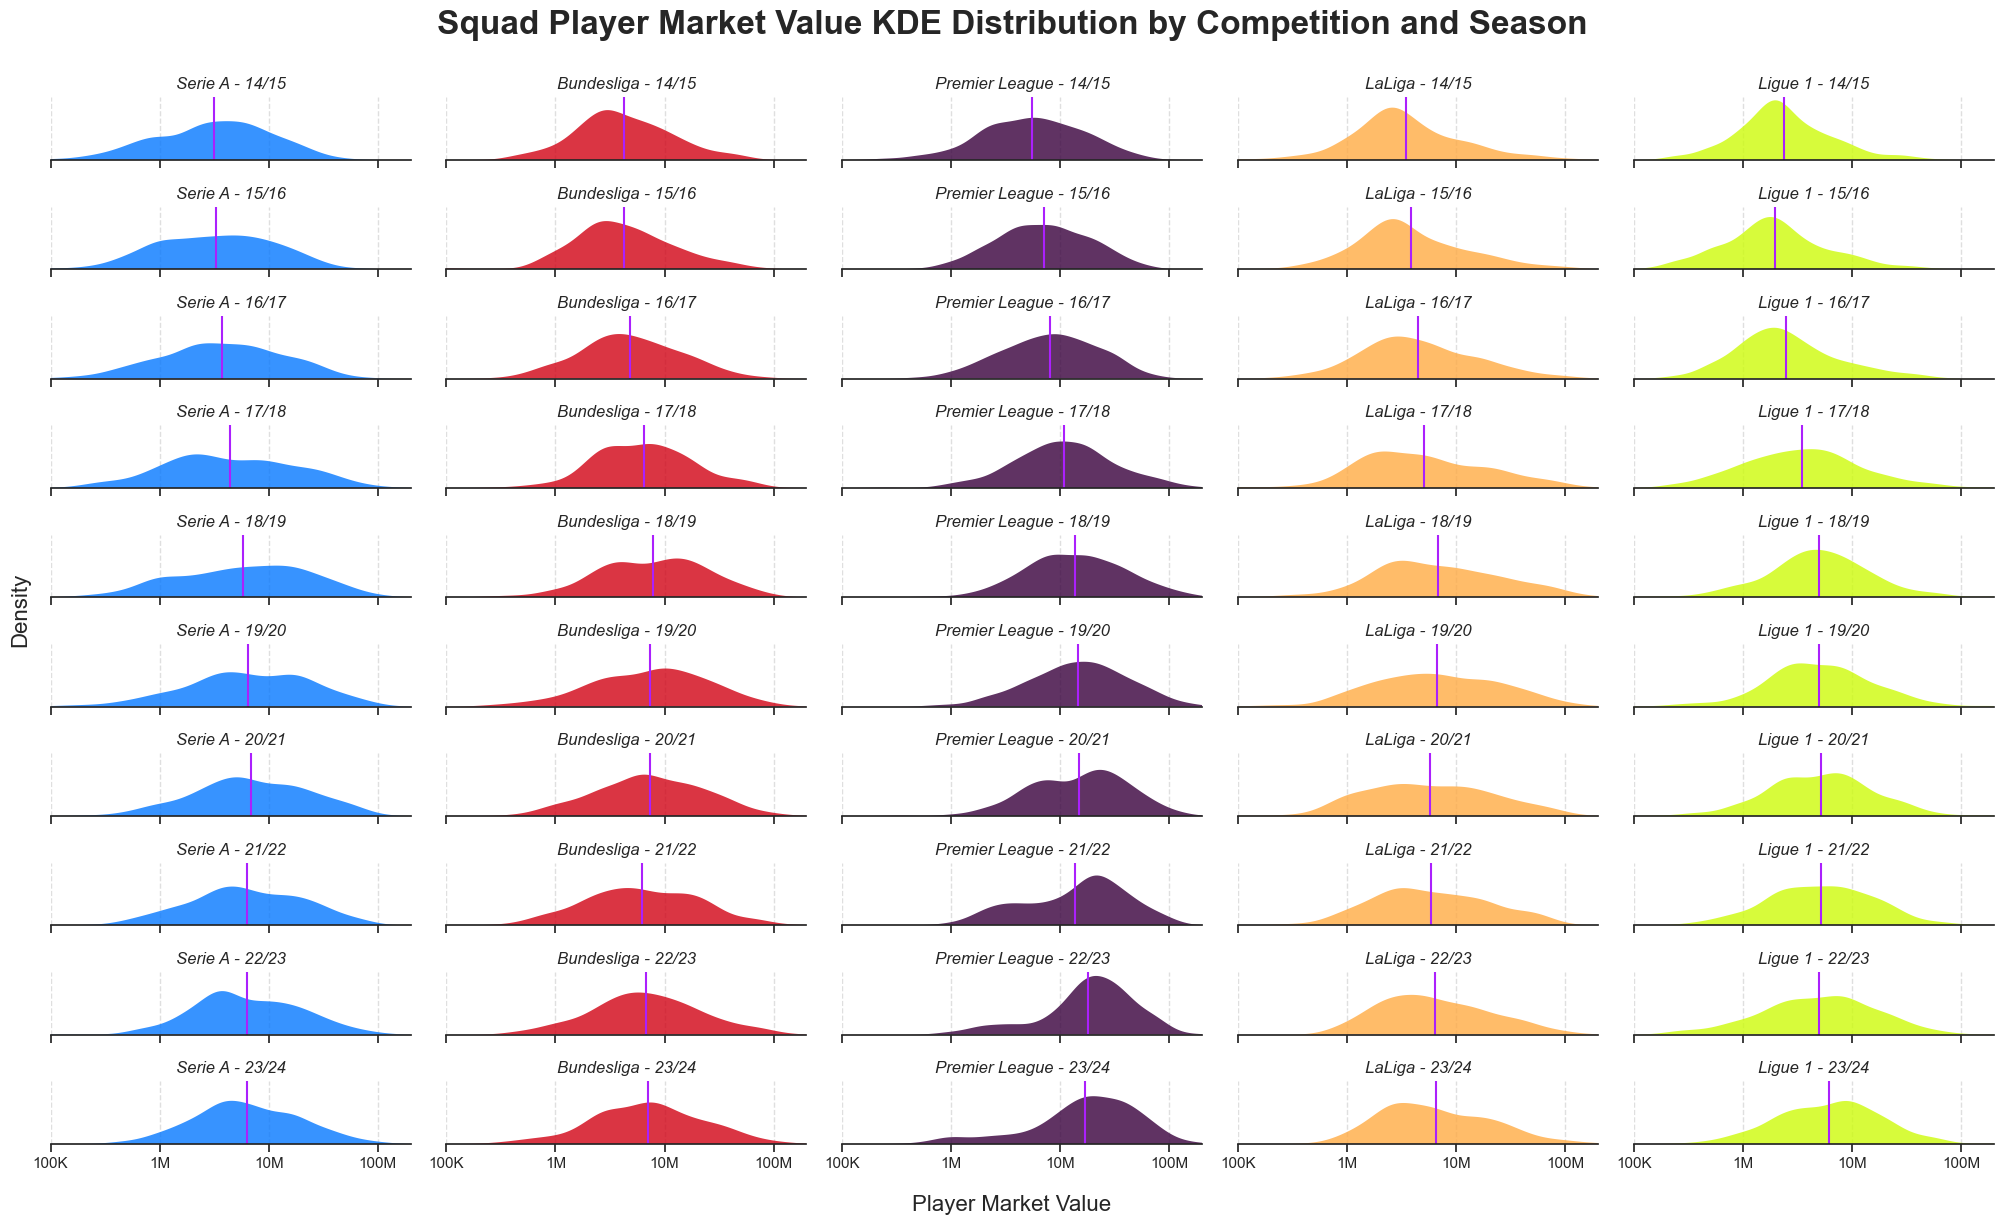

In [18]:
# Filtered for players who have at least played 450 minutes in the season (minimum set by FBREF scout reports)
sns.set_theme(style="white", palette="muted", rc={'xtick.bottom': True})

markt_val_viz_df_filtered = markt_val_viz_df[markt_val_viz_df['minutes_played'] >= 450].copy()

seasons = markt_val_viz_df_filtered['season'].unique()
competitions = markt_val_viz_df_filtered['competition_name'].unique()
min_log_val = markt_val_viz_df_filtered['log_market_value'].min()
max_log_val = markt_val_viz_df_filtered['log_market_value'].max()

adv_stats = []
fig, axes = plt.subplots(len(seasons), len(competitions), figsize=(20, 12), sharex=True, sharey=True)
for i, season in enumerate(seasons):
    for j, competition in enumerate(competitions):
        ax = axes[i, j]

        season_competition_data = markt_val_viz_df_filtered[
            (markt_val_viz_df_filtered['season'] == season) & 
            (markt_val_viz_df_filtered['competition_name'] == competition)
        ]

        # Calculating CV, Kurtosis, & Skew here...
        std_dev = season_competition_data['log_market_value'].std()
        mean_value = season_competition_data['log_market_value'].mean()
        cv = (std_dev / mean_value) * 100
        kurt = kurtosis(season_competition_data['log_market_value'], fisher=True)
        skewness = skew(season_competition_data['log_market_value'])
        
        adv_stats.append({'season': season, 'competition': competition, 'CV': cv, 'kurtosis': kurt, 'skewness': skewness})

        sns.kdeplot(x=season_competition_data['log_market_value'],
                    fill=True,
                    color=competition_colors.get(competition, '#000000'),
                    alpha=0.8,
                    edgecolor='none',
                    ax=ax)

        ax.axvline(mean_value, color='#ab20fd', linestyle='-', label=f'Mean: {mean_value:.2f}')

        x_ticks = [np.log(100000), np.log(1000000), np.log(10000000), np.log(100000000)]
        x_tick_labels = ['100K', '1M', '10M', '100M']
        ax.set_xticks(x_ticks, x_tick_labels)
        ax.set_xlim(min_log_val, max_log_val)
        ax.grid(axis='x', linestyle='--', color='grey', alpha=0.25)

        ax.set_yticks([])

        ax.set_title(f"{competition} - {season}", fontstyle='italic')
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

fig.suptitle('Squad Player Market Value KDE Distribution by Competition and Season', fontsize=24, y=1, weight='bold')
fig.text(0.5, -0.001, 'Player Market Value', ha='center', fontsize=16)
fig.text(-0.001, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.show()

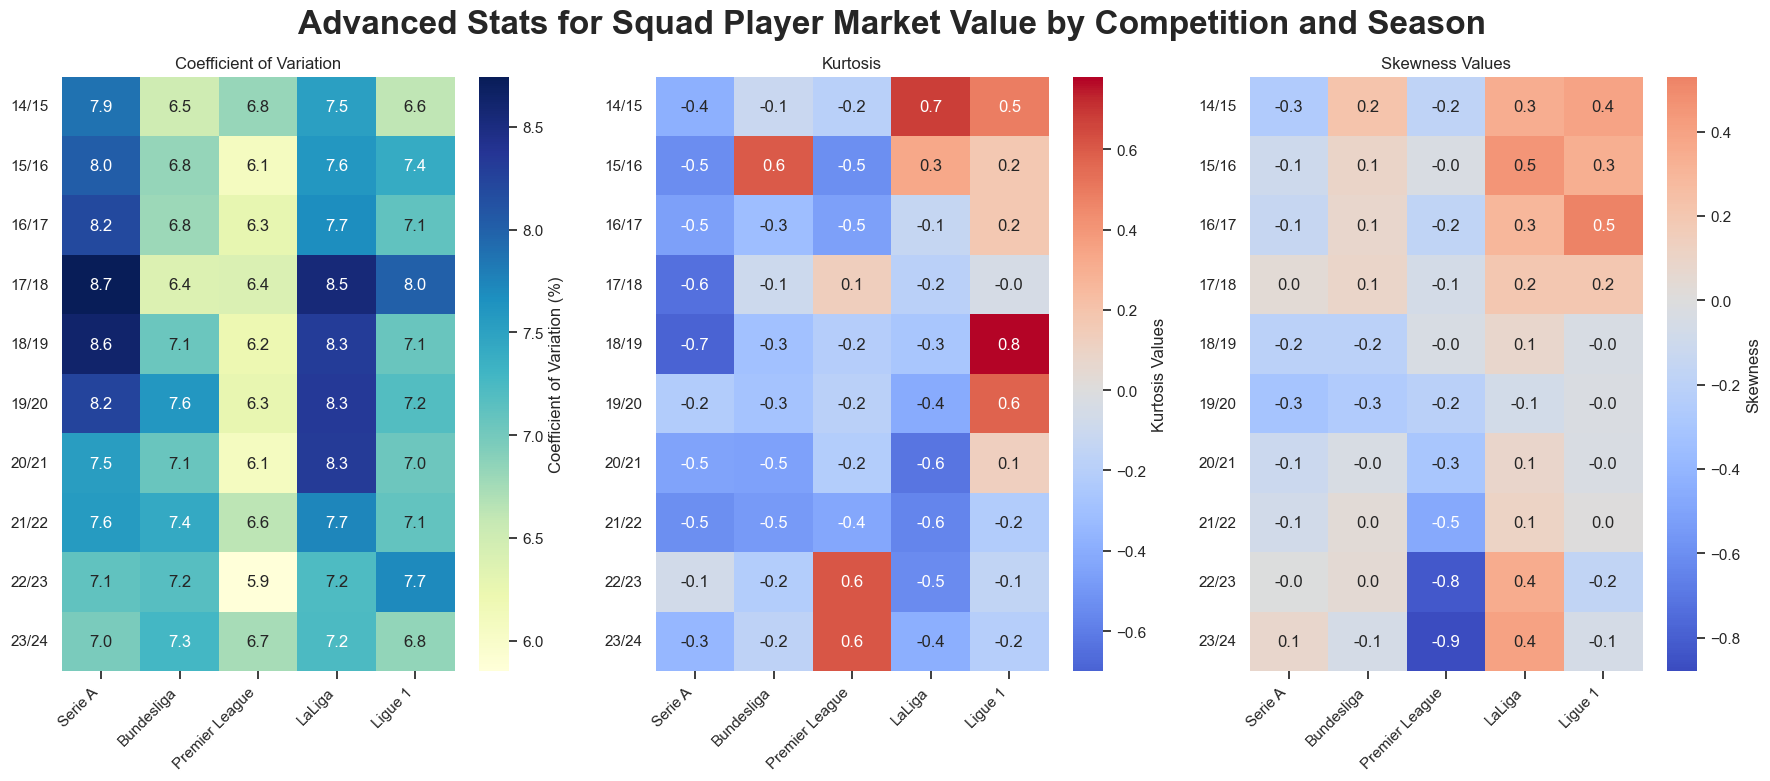

In [19]:
cv_df = pd.DataFrame(adv_stats)[['season', 'competition', 'CV']]
cv_pivot = cv_df.pivot(index='season', columns='competition', values='CV').reindex(columns=competitions)
kurt_df = pd.DataFrame(adv_stats)[['season', 'competition', 'kurtosis']]
kurt_pivot = kurt_df.pivot(index='season', columns='competition', values='kurtosis').reindex(columns=competitions)
skewness_df = pd.DataFrame(adv_stats)[['season', 'competition', 'skewness']]
skewness_pivot = skewness_df.pivot(index='season', columns='competition', values='skewness').reindex(columns=competitions)

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# CV Heatmap
sns.heatmap(cv_pivot,
            annot=True,
            fmt=".1f",
            cmap="YlGnBu",
            cbar_kws={'label': 'Coefficient of Variation (%)'},
            ax=axes[0])
axes[0].set_title("Coefficient of Variation", fontsize=12)
axes[0].set_xlabel("")
axes[0].set_ylabel("")
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Kurtosis Heatmap
sns.heatmap(kurt_pivot,
            annot=True,
            fmt=".1f",
            cmap="coolwarm",
            cbar_kws={'label': 'Kurtosis Values'},
            center=0.0,
            ax=axes[1])
axes[1].set_title("Kurtosis", fontsize=12)
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='y', rotation=0)

# Skewness Heatmap
sns.heatmap(skewness_pivot,
            annot=True,
            fmt=".1f",
            cmap="coolwarm",
            cbar_kws={'label': 'Skewness'},
            center=0.0,
            ax=axes[2])
axes[2].set_title("Skewness Values", fontsize=12)
axes[2].set_xlabel("")
axes[2].set_ylabel("")
axes[2].tick_params(axis='x', labelrotation=45)
axes[2].tick_params(axis='y', rotation=0)

axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right')
axes[2].set_xticklabels(axes[2].get_xticklabels(), ha='right')

fig.suptitle('Advanced Stats for Squad Player Market Value by Competition and Season', fontsize=24, y=.975, weight='bold')
plt.tight_layout()
plt.show()

__Notes:__
1. Average market value increases observed in largely every league but biggest seems to be in the Premier League.
2. Interesting to see that Ligue 1 has largely followed a 'normal' distribution, LaLiga has largely had right-skew, and Premier League was normally distributed in earlier seasons but now seems to have a more pronounced left skew.
3. Premier League in more recent seasons as developed a more pronounced arch between the 10 million and 100 million mark.
4. Ligue 1 over the seasons has gone from a large concentration of players in the low 1 - 10 million bracket, to a flatter & more even distribution. Does this suggest Ligue 1 has become a more even playing field in recent seasons? LaLiga has also gone through a similar 'flattening', especially seen in the 20/21 season. But more recently has been developming more of a bulge in the low 1-10 million range. Serie A seems to have gone through the opposite, while the Premier League had a 'bulge' present already that has gotten more concentrated.

_Looking at the CV for each competition & season pair..._


__Potentially wrong intepretaion below, fix soon:__
1. The Premier League seems to consistently have lower CV values, meaning that it's market values are much more concentrated around it's market values, possibly indicating less diversity in terms of 'squad' player market value profiles relative to the other competitions.
2. Serie A & La Liga on the other seemed to have had greater CV values, especially during the 17/18-19/20 seasons. But more, recently it has declined, suggesting that previously there was a greater range of different 'squad' player market value profiles which is now lowered.
3. Ligue 1 has stayed relatively around 7% with some spikes in some seasons while Bundesliga interestingly seems to have increased diversity in 'squad' player market value profiles.

##### Average Market Value Change Every Season

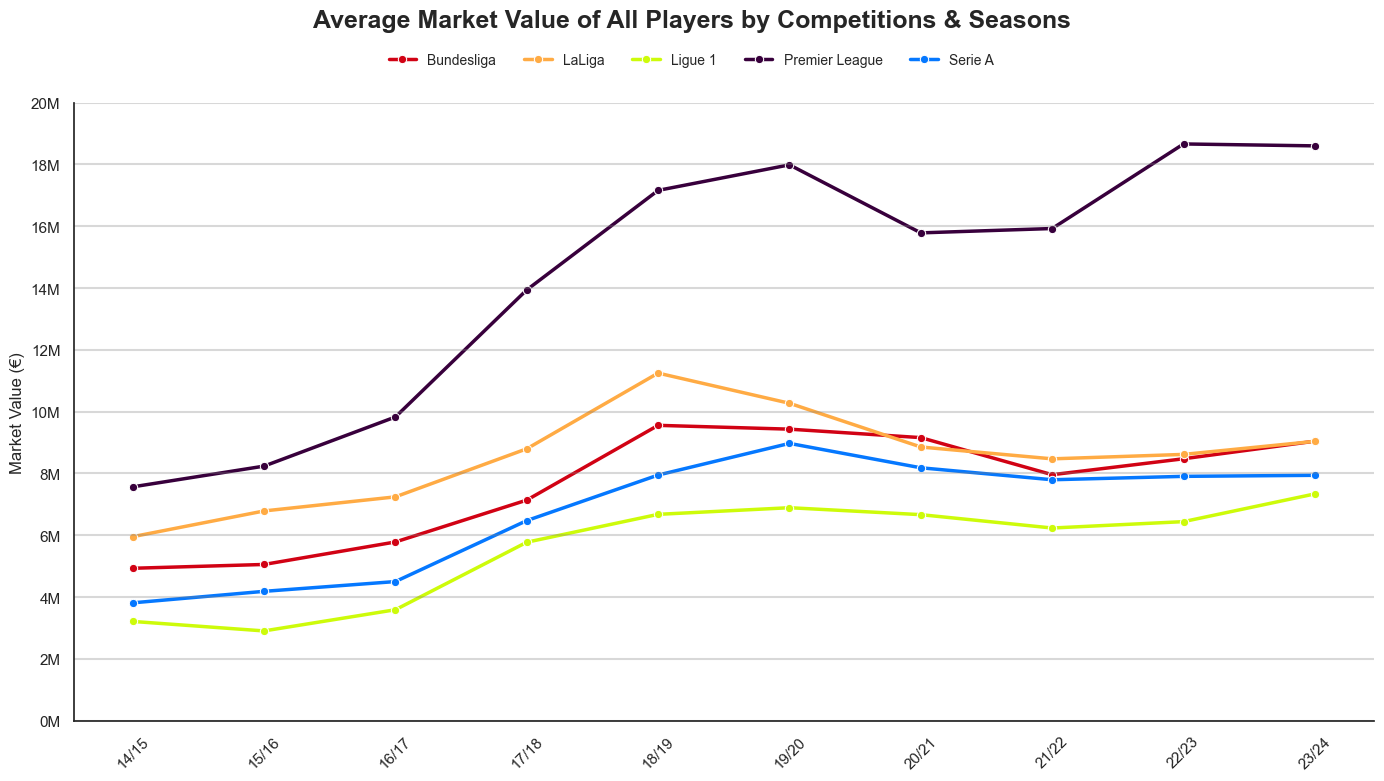

In [20]:
avg_markt_val_seasons = markt_val_viz_df.groupby(['competition_name', 'season'], observed=True)['market_value_euros'].mean().reset_index()

sns.set_theme(style="white", palette="muted")
fig, ax = plt.subplots(figsize=(14, 8))

sns.lineplot(data=avg_markt_val_seasons,
             x='season',
             y='market_value_euros',
             hue='competition_name',
             marker='o',
             linewidth=2.5,
             palette=competition_colors,
             ax=ax)

fig.suptitle("Average Market Value of All Players by Competitions & Seasons", 
             fontsize=18, 
             fontweight='bold', 
             y=.975)
plt.xlabel("")
plt.ylabel("Market Value (€)", fontsize=12)

plt.xticks(rotation=45)
plt.yticks(np.arange(0, 21000000,2000000))

for ytick in plt.gca().get_yticks():
    plt.axhline(y=ytick, color='gray', linestyle='-', alpha=0.3)
sns.despine(left=False, bottom=False, right=True, top=True)

def millions_formatter(x, _):
    return f"{x / 1e6:.0f}M"

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.ylim(bottom=0)

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.475, 1.1),
           ncol=5,
           frameon=False,
           fontsize=10,
           title="")

plt.tight_layout()
plt.show()

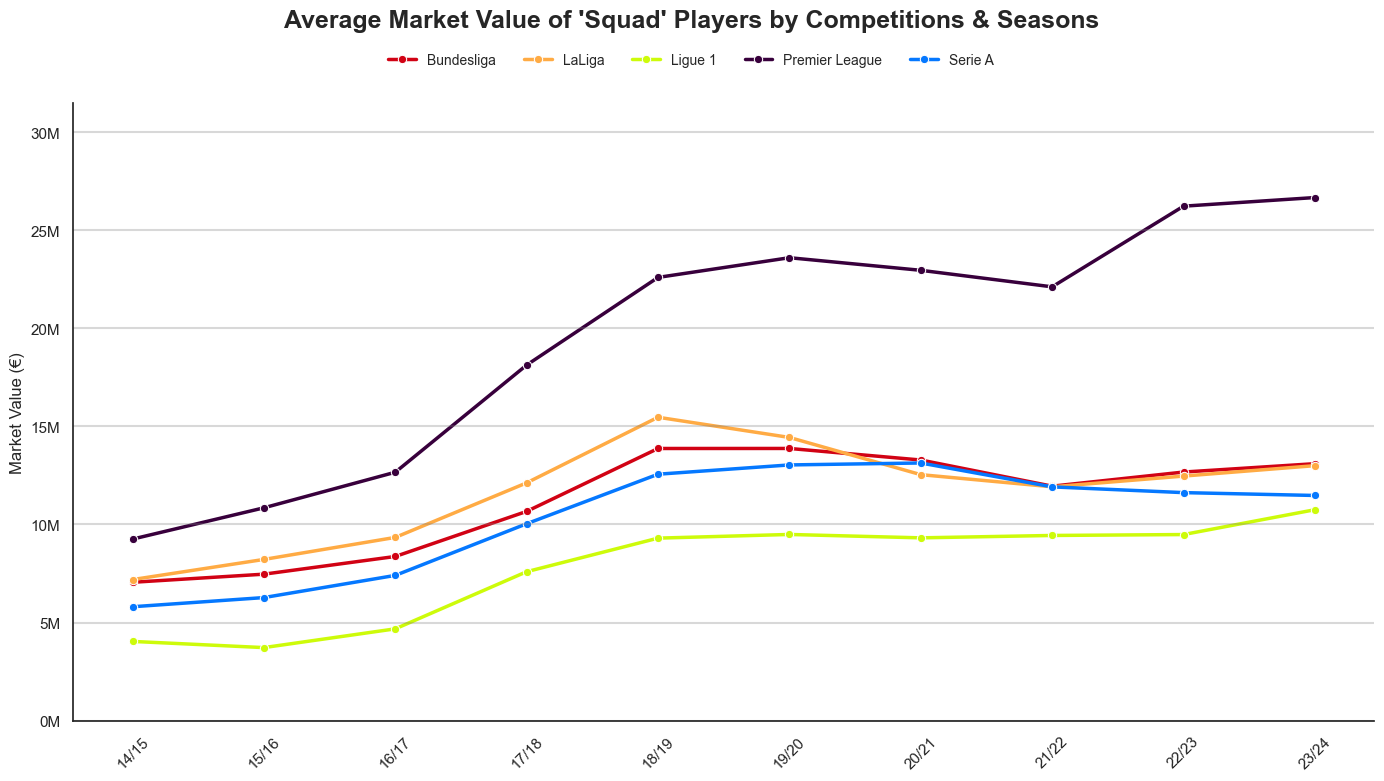

In [21]:
filt_markt_val_viz_df = markt_val_viz_df[markt_val_viz_df['minutes_played'] >= 450].copy()
avg_markt_val_seasons = filt_markt_val_viz_df.groupby(['competition_name', 'season'], observed=True)['market_value_euros'].mean().reset_index()

sns.set_theme(style="white", palette="muted")
fig, ax = plt.subplots(figsize=(14, 8))

sns.lineplot(data=avg_markt_val_seasons,
             x='season',
             y='market_value_euros',
             hue='competition_name',
             marker='o',
             linewidth=2.5,
             palette=competition_colors,
             ax=ax)

fig.suptitle("Average Market Value of 'Squad' Players by Competitions & Seasons", 
             fontsize=18, 
             fontweight='bold', 
             y=.975)
plt.xlabel("")
plt.ylabel("Market Value (€)", fontsize=12)

plt.xticks(rotation=45)

for ytick in plt.gca().get_yticks():
    plt.axhline(y=ytick, color='gray', linestyle='-', alpha=0.3)
sns.despine(left=False, bottom=False, right=True, top=True)

def millions_formatter(x, _):
    return f"{x / 1e6:.0f}M"

ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.ylim(bottom=0)

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.475, 1.1),
           ncol=5,
           frameon=False,
           fontsize=10,
           title="")

plt.tight_layout()
plt.show()

#### `age_when_assessed`

In [22]:
age_dist_viz_df = clean_players_df \
                                .sort_values(by=['season', 'competition_id', 'club_id', 'player_id', 'age_when_assessed']) \
                                .drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id'],
                                                 keep='first') \
                                .copy()

# Obtaining player age at start of season (August 1st)
season_start_year = '20' + age_dist_viz_df['season'].str.split('/').str[0]
season_start_date = pd.to_datetime(season_start_year + '-08-01')

age_season_start = season_start_date.dt.year - age_dist_viz_df['date_of_birth'].dt.year
age_season_start -= ((season_start_date.dt.month < age_dist_viz_df['date_of_birth'].dt.month) | 
                     ((season_start_date.dt.month == age_dist_viz_df['date_of_birth'].dt.month) & 
                      (season_start_date.dt.day < age_dist_viz_df['date_of_birth'].dt.day)))

age_dist_viz_df['age_season_start'] = age_season_start
display(age_dist_viz_df[age_dist_viz_df['player_name'] == 'Eden Hazard'][['player_name', 'season', 'age_season_start']])

,player_name,season,age_season_start
63221,Eden Hazard,14/15,23
63218,Eden Hazard,15/16,24
63215,Eden Hazard,16/17,25
63213,Eden Hazard,17/18,26
63209,Eden Hazard,18/19,27
63206,Eden Hazard,19/20,28
63202,Eden Hazard,20/21,29
63198,Eden Hazard,21/22,30
63195,Eden Hazard,22/23,31


##### General Age Distribution

##### Age Distribution by Competition & Season

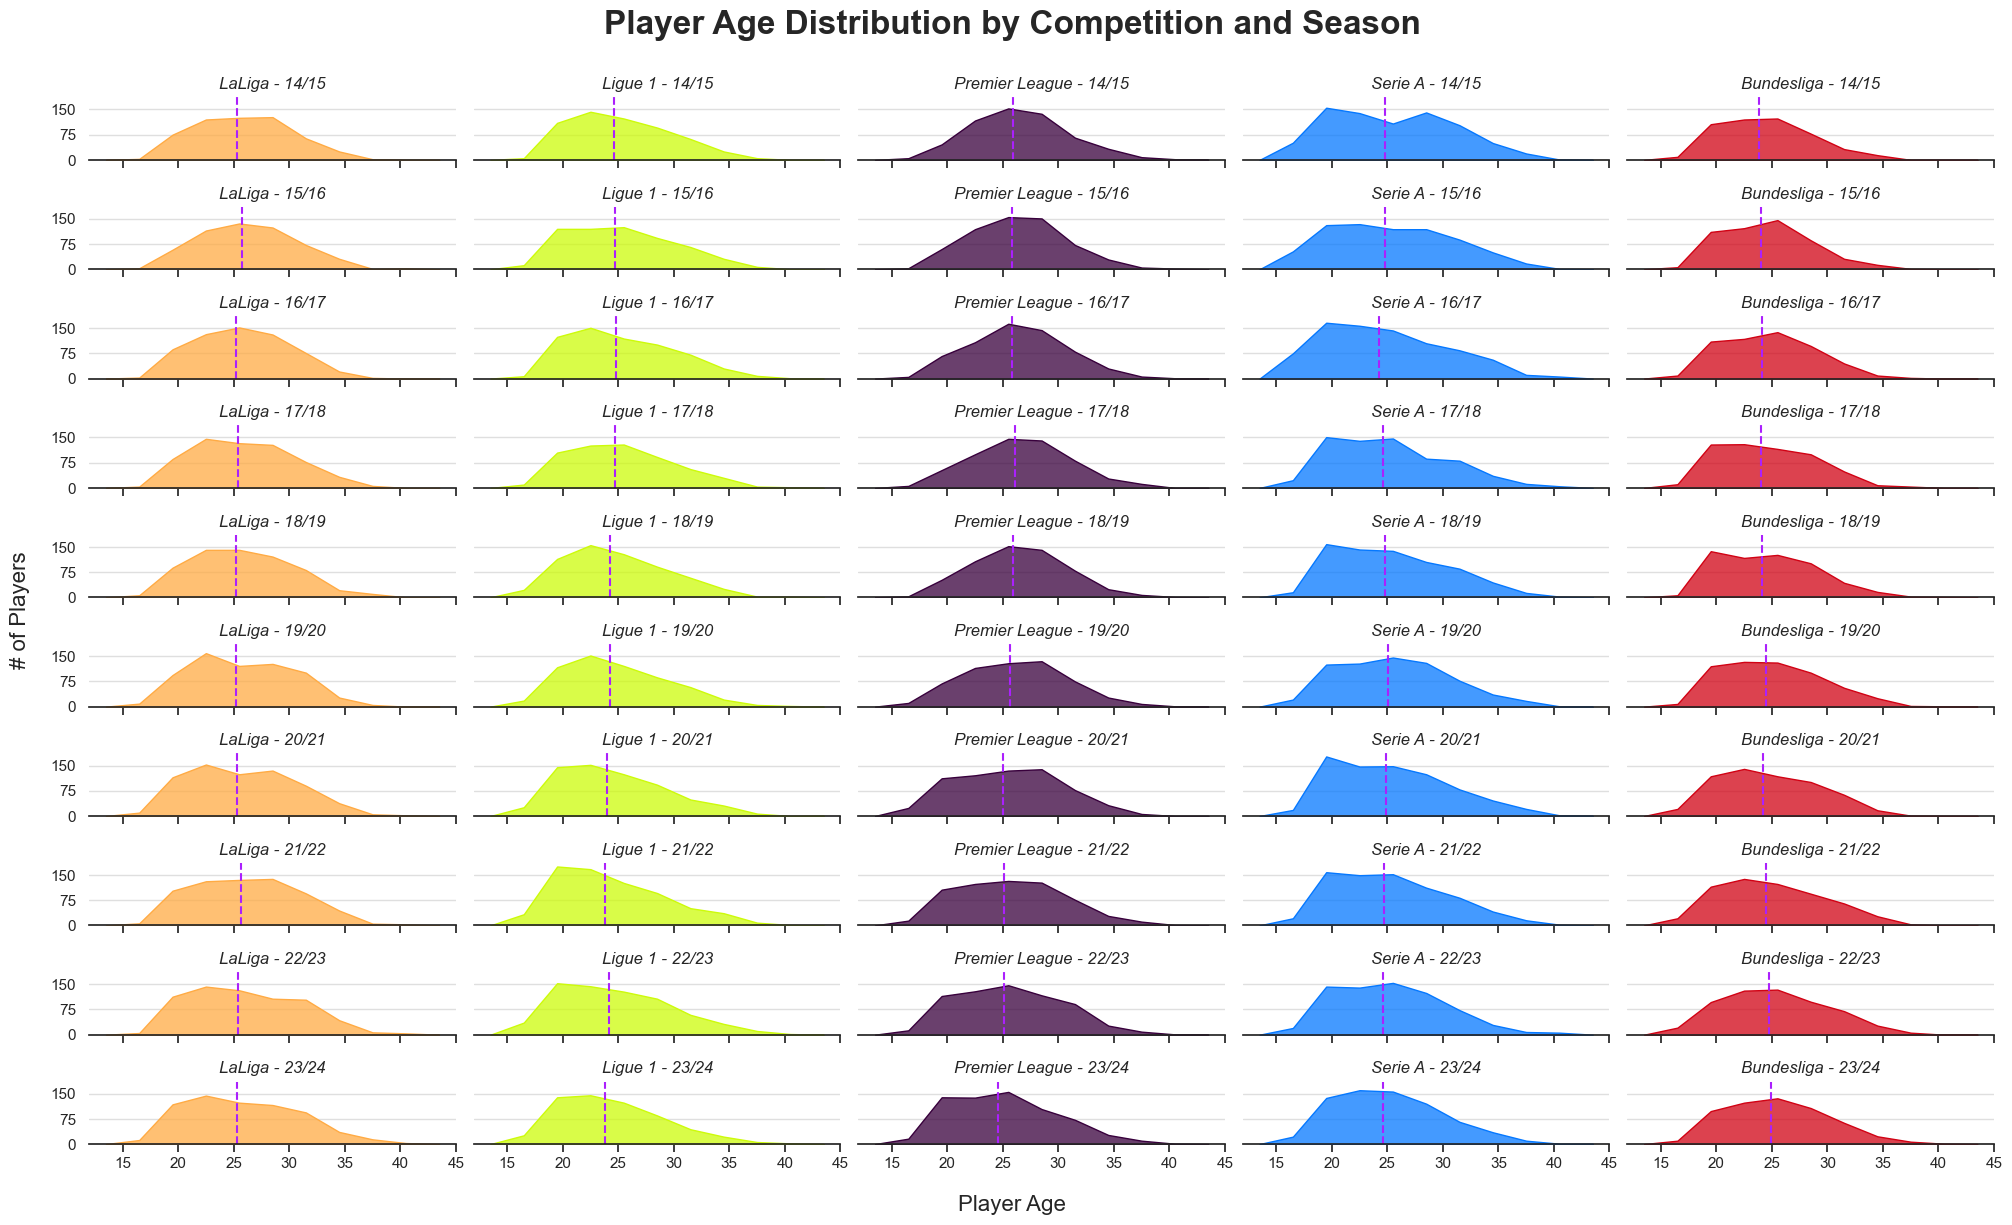

In [23]:
sns.set_theme(style="white", palette="muted", rc={'xtick.bottom': True})

seasons = age_dist_viz_df['season'].unique()
competitions = age_dist_viz_df['competition_name'].unique()
min_age = age_dist_viz_df['age_season_start'].min()
max_age = age_dist_viz_df['age_season_start'].max()

fig, axes = plt.subplots(len(seasons), len(competitions), figsize=(20, 12), sharex=True, sharey=True)
for i, season in enumerate(seasons):
    for j, competition in enumerate(competitions):
        ax = axes[i, j]

        season_competition_data = age_dist_viz_df[
            (age_dist_viz_df['season'] == season) & 
            (age_dist_viz_df['competition_name'] == competition)
        ]

        sns.histplot(season_competition_data['age_season_start'], ax=ax, kde=False,
                     bins=range(min_age - 3, max_age + 3, 3),
                     element="poly",
                     color=competition_colors.get(competition, '#000000'))

        mean_age = season_competition_data['age_season_start'].mean()
        ax.axvline(mean_age, color='#ab20fd', linestyle='--', label=f'Mean: {mean_age:.2f}')

        ax.set_yticks([0, 75, 150])
        ax.set_title(f"{competition} - {season}", fontstyle='italic')
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='y', linestyle='-', color='grey', alpha=0.25)

fig.suptitle('Player Age Distribution by Competition and Season', fontsize=24, y=1, weight='bold')
fig.text(0.5, -0.001, 'Player Age', ha='center', fontsize=16)
fig.text(-0.001, 0.5, '# of Players', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.show()

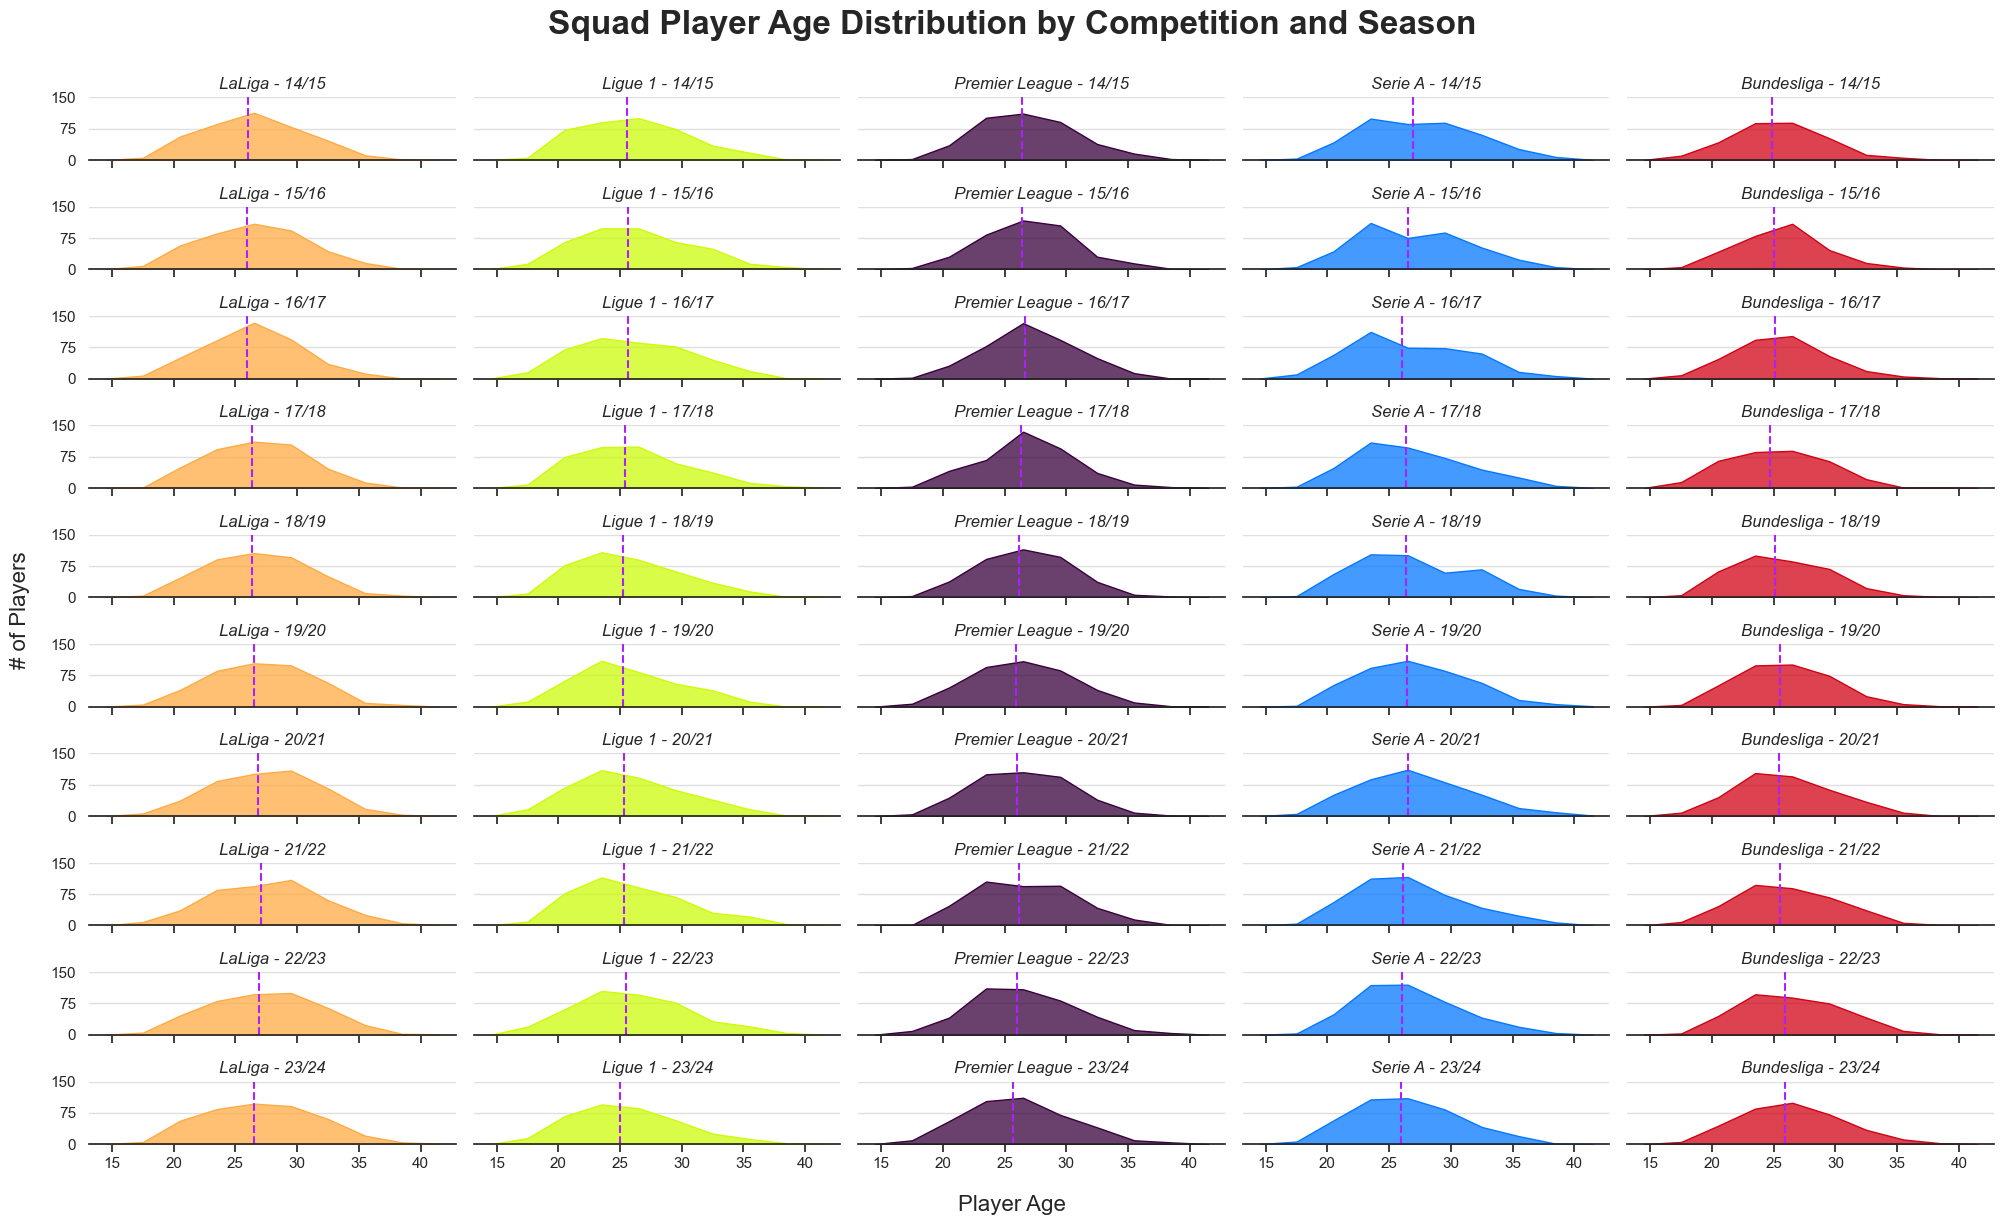

In [24]:
# For 'squad' players
sns.set_theme(style="white", palette="muted", rc={'xtick.bottom': True})

age_dist_viz_df_filtered = age_dist_viz_df[age_dist_viz_df['minutes_played'] >= 450].copy()

seasons = age_dist_viz_df_filtered['season'].unique()
competitions = age_dist_viz_df_filtered['competition_name'].unique()
min_age = age_dist_viz_df_filtered['age_season_start'].min()
max_age = age_dist_viz_df_filtered['age_season_start'].max()

fig, axes = plt.subplots(len(seasons), len(competitions), figsize=(20, 12), sharex=True, sharey=True)
for i, season in enumerate(seasons):
    for j, competition in enumerate(competitions):
        ax = axes[i, j]

        season_competition_data = age_dist_viz_df_filtered[
            (age_dist_viz_df_filtered['season'] == season) & 
            (age_dist_viz_df_filtered['competition_name'] == competition)
        ]

        sns.histplot(season_competition_data['age_season_start'], ax=ax, kde=False,
                     bins=range(min_age - 3, max_age + 3, 3),
                     element="poly",
                     color=competition_colors.get(competition, '#000000'))

        mean_age = season_competition_data['age_season_start'].mean()
        ax.axvline(mean_age, color='#ab20fd', linestyle='--', label=f'Mean: {mean_age:.2f}')

        ax.set_yticks([0, 75, 150])
        ax.set_title(f"{competition} - {season}", fontstyle='italic')
        ax.set_xlabel(' ')
        ax.set_ylabel(' ')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='y', linestyle='-', color='grey', alpha=0.25)

fig.suptitle('Squad Player Age Distribution by Competition and Season', fontsize=24, y=1, weight='bold')
fig.text(0.5, -0.001, 'Player Age', ha='center', fontsize=16)
fig.text(-0.001, 0.5, '# of Players', va='center', rotation='vertical', fontsize=16)
plt.tight_layout()
plt.show()

#### `primary_citizenship`

In [25]:
nationality_dist_viz_df = clean_players_df \
                                .drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id'],
                                                 keep='first') \
                                .copy()
nationality_counts = nationality_dist_viz_df['primary_citizenship'].value_counts()

##### General Measures of Nationalities in Dataset

In [26]:
top_nationalities = nationality_counts.head(10)
top_nationalities['Others'] = nationality_counts.iloc[10:].sum()

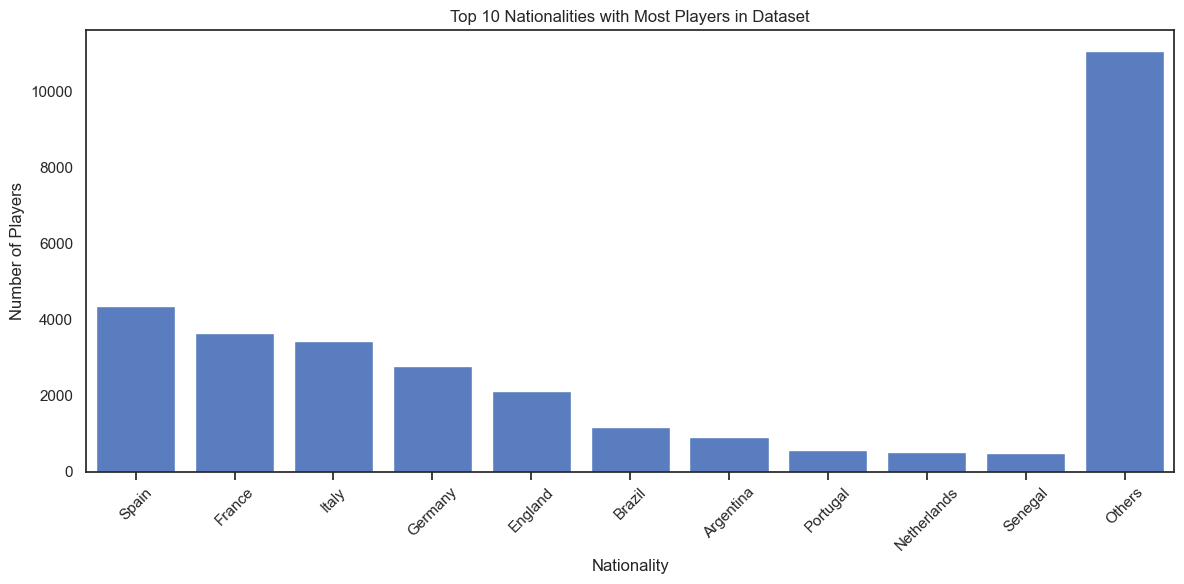

In [27]:
plt.figure(figsize=(12, 6))

sns.barplot(x=top_nationalities.index,
            y=top_nationalities.values)

plt.title("Top 10 Nationalities with Most Players in Dataset")
plt.xlabel("Nationality")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

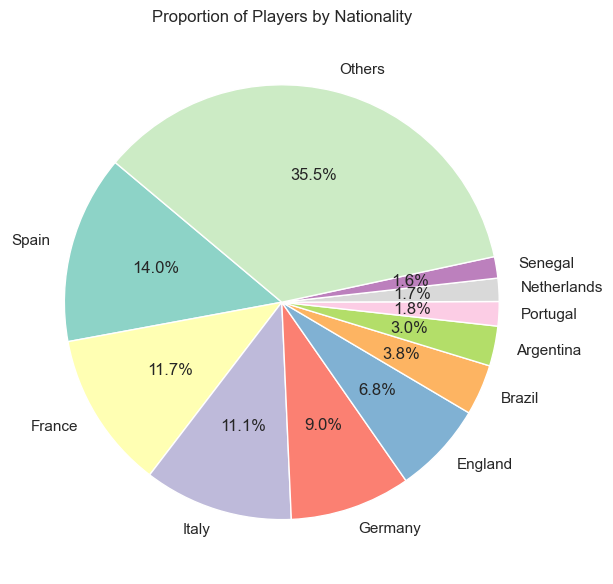

In [28]:
plt.figure(figsize=(12, 6))

top_nationalities.plot(kind='pie',
                       autopct='%1.1f%%',
                       startangle=140,
                       colors=sns.color_palette("Set3", len(top_nationalities)))
plt.title("Proportion of Players by Nationality")
plt.ylabel("")
plt.tight_layout()
plt.show()

##### Proportion of Native Players in Top 5 Leagues

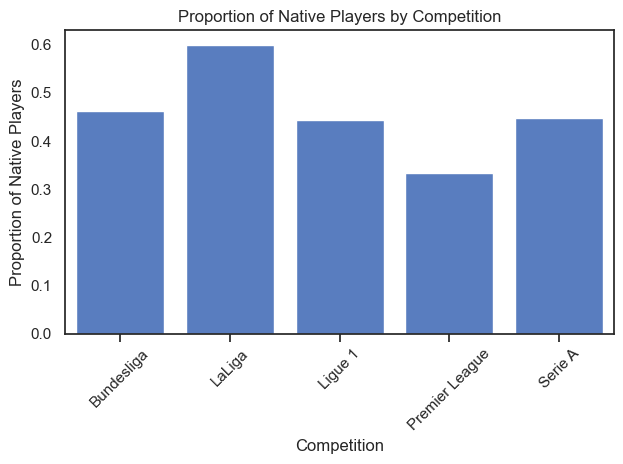

In [29]:
league_countries = {
    'Premier League': 'England',
    'LaLiga': 'Spain',
    'Serie A': 'Italy',
    'Bundesliga': 'Germany',
    'Ligue 1': 'France'
}

nationality_dist_viz_df['is_native'] = nationality_dist_viz_df.apply(lambda x: x['primary_citizenship'] == league_countries.get(x['competition_name'], ''), axis=1)
native_proportion = nationality_dist_viz_df.groupby('competition_name', observed=True)['is_native'].mean()

sns.barplot(x=native_proportion.index,
            y=native_proportion.values)

plt.title("Proportion of Native Players by Competition")
plt.xlabel("Competition")
plt.ylabel("Proportion of Native Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

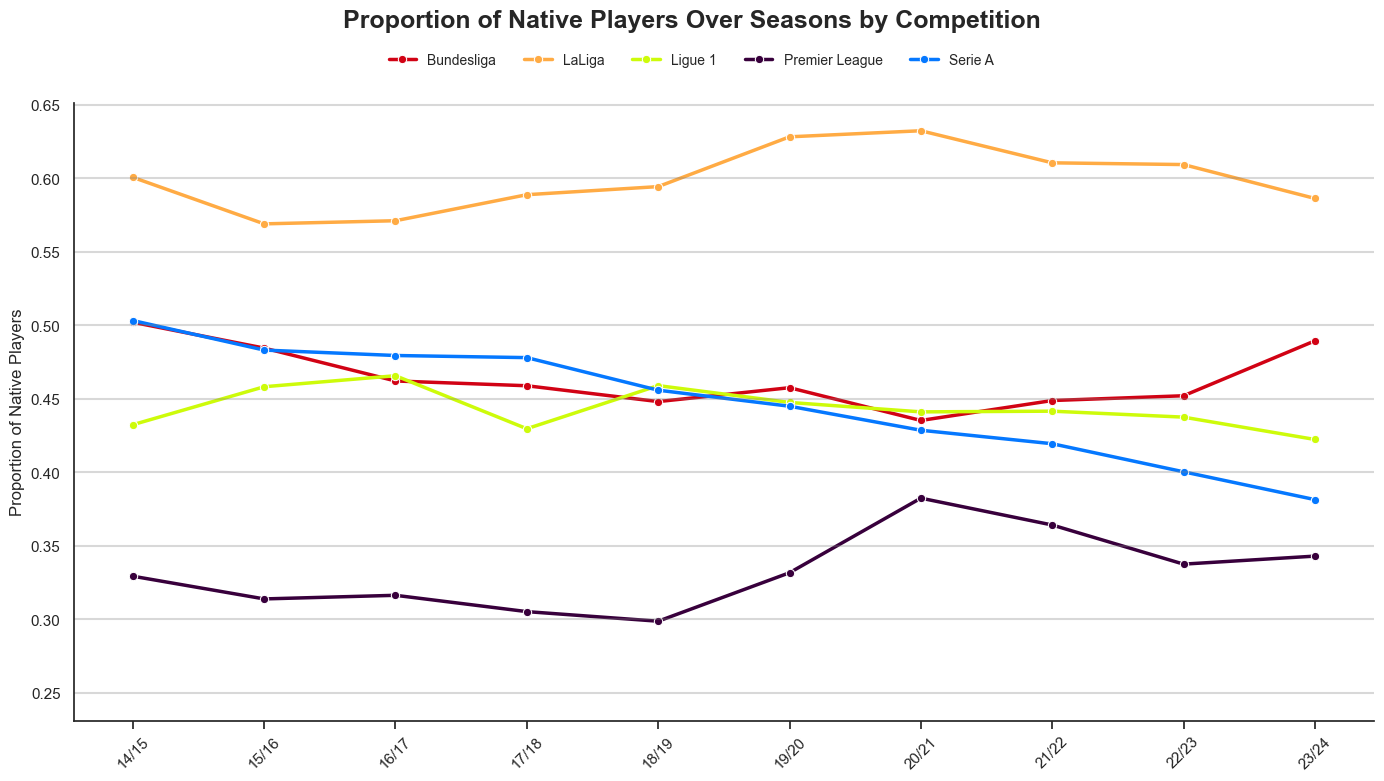

In [30]:
native_trend = nationality_dist_viz_df.groupby(['season', 'competition_name'], observed=True)['is_native'].mean().reset_index()

# Time Series Plot
fig, ax = plt.subplots(figsize=(14, 8))

sns.lineplot(data=native_trend,
             x='season',
             y='is_native',
             hue='competition_name',
             marker='o',
             linewidth=2.5,
             palette=competition_colors,
             ax=ax)

fig.suptitle("Proportion of Native Players Over Seasons by Competition", 
             fontsize=18, 
             fontweight='bold', 
             y=.975)
plt.xlabel("")
plt.ylabel("Proportion of Native Players", fontsize=12)

plt.xticks(rotation=45)

for ytick in plt.gca().get_yticks():
    plt.axhline(y=ytick, color='gray', linestyle='-', alpha=0.3)
sns.despine(left=False, bottom=False, right=True, top=True)

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.475, 1.1),
           ncol=5,
           frameon=False,
           fontsize=10,
           title="")

plt.tight_layout()
plt.show()

__NOTE:__
* Native is defined here by `primary_citizenship` and not by each competition's local definition of 'native'.

#### `appearances`, `minutes_played`

In [31]:
appearances_dist_viz_df = clean_players_df \
                                .drop_duplicates(subset=['season', 'competition_id', 'club_id', 'player_id'],
                                                 keep='first') \
                                .copy()

##### # of Different Player Appearances in Top 5 Leagues

In [32]:
# Basically, of all the players in the dataset, only these number of players actually made an appearance
appeared_in_competition_df = appearances_dist_viz_df[appearances_dist_viz_df['appearances'] > 0]
appeared_in_competition_df[['competition_name']].value_counts()

competition_name
Serie A             5736
LaLiga              5439
Ligue 1             5290
Premier League      5150
Bundesliga          4599
Name: count, dtype: int64

##### Distribution of Minutes Played

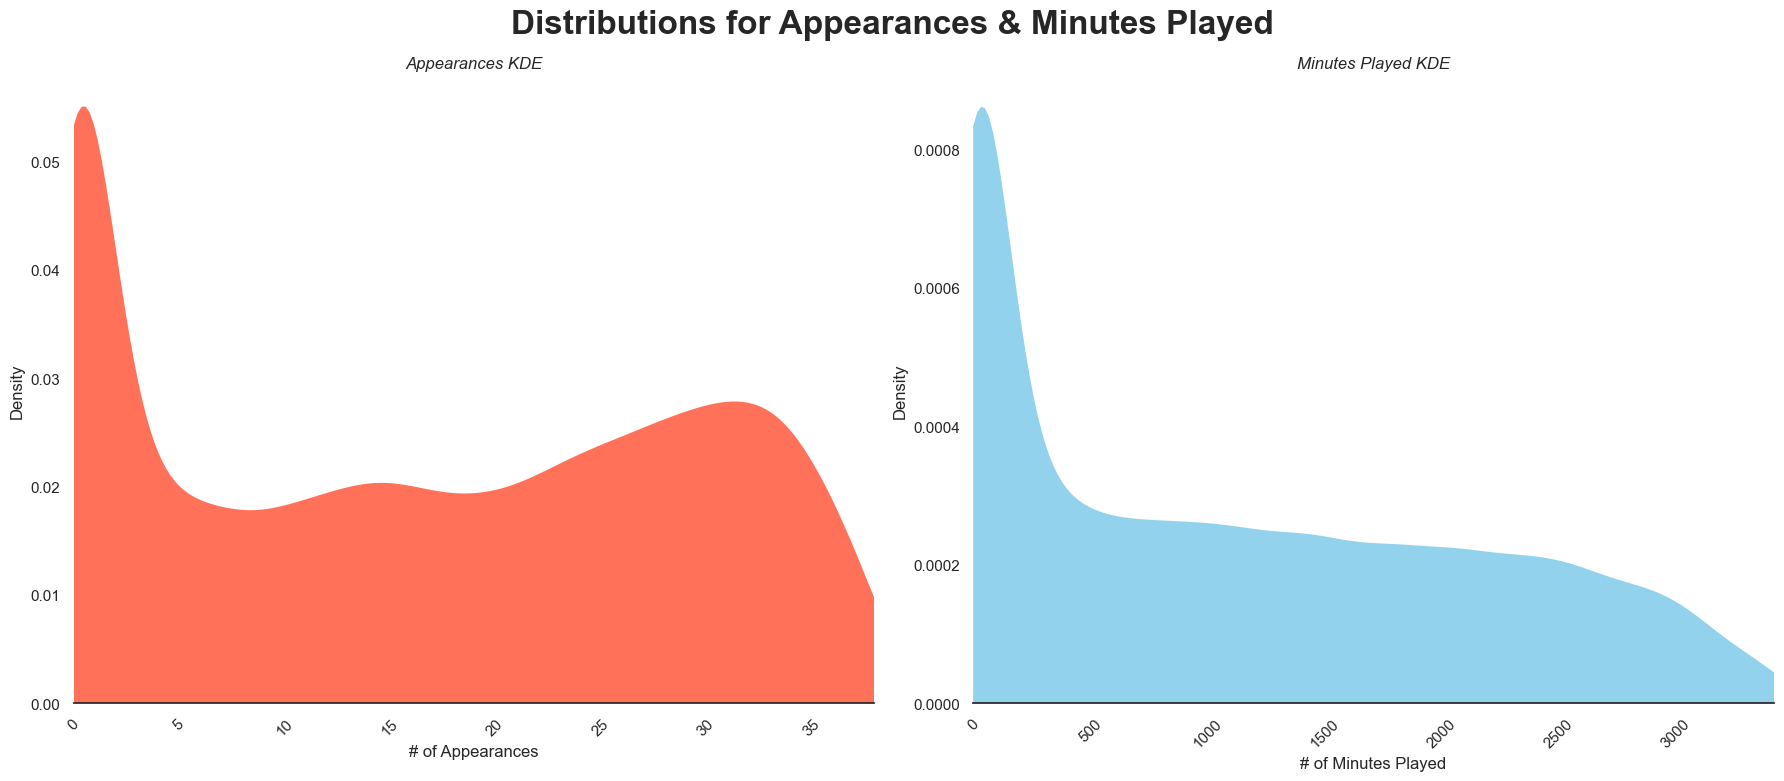

In [33]:
sns.set_theme(style="white", palette="muted")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.kdeplot(
    data=appearances_dist_viz_df,
    x='appearances',
    fill=True,
    color='tomato',
    linewidth=2,
    alpha=0.9,
    edgecolor='none',
    clip=(appearances_dist_viz_df['appearances'].min(), appearances_dist_viz_df['appearances'].max()),
    ax=axes[0],
)
axes[0].set_title("Appearances KDE", fontsize=12, fontstyle='italic')
axes[0].set_xlabel("# of Appearances")
axes[0].set_ylabel("Density")
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].tick_params(axis='y', rotation=0)
axes[0].set_xlim(appearances_dist_viz_df['appearances'].min(), appearances_dist_viz_df['appearances'].max())
axes[0].spines['top'].set_visible(False); axes[0].spines['right'].set_visible(False); axes[0].spines['left'].set_visible(False)

sns.kdeplot(
    data=appearances_dist_viz_df,
    x='minutes_played',
    fill=True,
    color='skyblue',
    linewidth=2,
    alpha=0.9,
    edgecolor='none',
    clip=(appearances_dist_viz_df['minutes_played'].min(), appearances_dist_viz_df['minutes_played'].max()),
    ax=axes[1]
)
axes[1].set_title("Minutes Played KDE", fontsize=12, fontstyle='italic')
axes[1].set_xlabel("# of Minutes Played")
axes[1].set_ylabel("Density")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='y', rotation=0)
axes[1].set_xlim(appearances_dist_viz_df['minutes_played'].min(), appearances_dist_viz_df['minutes_played'].max())
axes[1].spines['top'].set_visible(False); axes[1].spines['right'].set_visible(False); axes[1].spines['left'].set_visible(False)

fig.suptitle('Distributions for Appearances & Minutes Played', fontsize=24, y=.975, weight='bold')
plt.tight_layout()
plt.show()

##### Boxplots of Minutes Played Across Top 5 Leagues

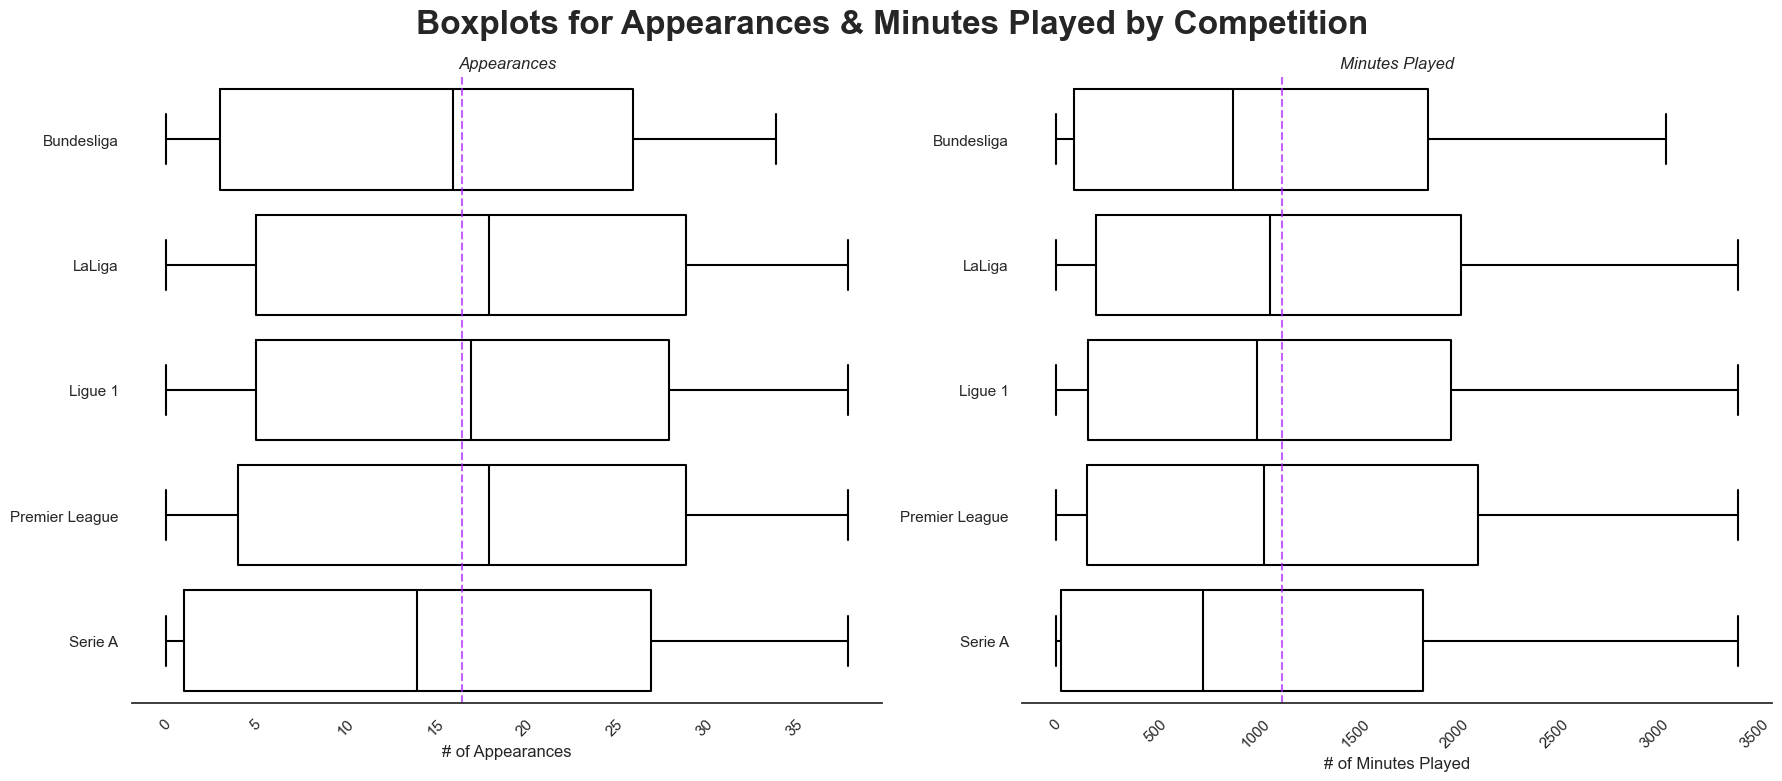

In [328]:
sns.set_theme(style="white", palette="muted")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.boxplot(
    data=appearances_dist_viz_df,
    x='appearances',
    y='competition_name',
    color='black',
    saturation=0.5,
    fill=False,
    ax=axes[0],
)
mean_appearances = appearances_dist_viz_df['appearances'].mean()
axes[0].axvline(mean_appearances, color='#ab20fd', linestyle='--', alpha=0.7)
axes[0].set_title("Appearances", fontsize=12, fontstyle='italic')
axes[0].set_xlabel("# of Appearances")
axes[0].set_ylabel("")
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].tick_params(axis='y', rotation=0)
axes[0].spines['top'].set_visible(False); axes[0].spines['right'].set_visible(False); axes[0].spines['left'].set_visible(False)

sns.boxplot(
    data=appearances_dist_viz_df,
    x='minutes_played',
    y='competition_name',
    color='black',
    saturation=0.5,
    fill=False,
    ax=axes[1],
)
mean_minutes_played = appearances_dist_viz_df['minutes_played'].mean()
axes[1].axvline(mean_minutes_played, color='#ab20fd', linestyle='--', alpha=0.7)
axes[1].set_title("Minutes Played", fontsize=12, fontstyle='italic')
axes[1].set_xlabel("# of Minutes Played")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='y', rotation=0)
axes[1].spines['top'].set_visible(False); axes[1].spines['right'].set_visible(False); axes[1].spines['left'].set_visible(False)

fig.suptitle('Boxplots for Appearances & Minutes Played by Competition', fontsize=24, y=.975, weight='bold')
plt.tight_layout()
plt.show()

__NOTE:__
* Mean of both the variables is shown by purple dashed line

##### _"Is there a way we can divide players into reserves, subs, and starters?"_

#### `jersey_number` & `main_position`

In [48]:
display(clean_players_df[['jersey_number', 'main_position', 'other_positions']].head())
print(clean_players_df['main_position'].value_counts(dropna=False))
print()
print(clean_players_df['other_positions'].value_counts(dropna=False))
display(clean_players_df.query('main_position == "Central Midfield" and other_positions.isnull()')['player_name'].unique())

'''
1. First condense main_position into general position -> goalkeeper, defender, midfielder, wide roles, forward
2. Maybe try
'''

,jersey_number,main_position,other_positions
21133,11,Centre-Forward,NaN
21134,11,Centre-Forward,NaN
21131,11,Centre-Forward,NaN
21132,11,Centre-Forward,NaN
20390,1,Goalkeeper,NaN


main_position
Centre-Back           14352
Centre-Forward        10464
Central Midfield      10402
Goalkeeper             8660
Defensive Midfield     7171
Right-Back             6518
Left-Back              5878
Right Winger           5216
Left Winger            4925
Attacking Midfield     4877
Second Striker          552
Right Midfield          515
Left Midfield           483
Name: count, dtype: int64

other_positions
NaN                                 21628
Central Midfield                     3816
Defensive Midfield                   3364
Right-Back                           2457
Left-Back                            2446
                                    ...  
Defensive Midfield, Left Winger         2
Right Winger, Defensive Midfield        2
Right-Back, Left Winger                 1
Right Winger, Centre-Back               1
Second Striker, Right-Back              1
Name: count, Length: 134, dtype: int64


array(['Daniele Dessena', 'Aritz López Garai', 'Erik Morán',
       'Anders Christiansen', 'Alejandro Faurlín', 'Darko Brasanac',
       'Ledian Memushaj', 'Jon Errasti', 'El-Hadji Ba', 'Fausto Tienza',
       'Alberto Martín', 'Ramiro Guerra', 'Antonio Romano',
       'Filippo Bandinelli', 'Roberto Olabe', 'Nicola Guglielmelli',
       "N'Diaye Djiby", 'Luzayadio Bangu', 'Borja Fernández',
       'Martín Calderón', 'Lorenzo Capezzani', 'Imanol Sarriegi',
       'Riccardo Gaiola', 'Alimeyaw Salifu', 'Emmanuel Besea',
       'Alberto Picchi', 'Dani Molina', 'Álex López', 'Mathias Jensen',
       'Andrea Gulli', 'Raúl Guti', 'Mattia Bonetto', 'Stephane Omeonga',
       'Tom Dele-Bashiru', 'Pablo Larrea', 'Fabrizio Caligara',
       'Andrea Tessiore', 'Massimo Bertagnoli', 'Giordano Trovade',
       'Pol Lozano', 'Alexis Larriere', 'Matteo Rossetti',
       'Imanol García', 'Víctor San Bartolomé', 'Andrea Errico',
       'Mamadou Coulibaly', 'Thomas Battistella', 'Moha Moukhliss',
       

'\n1. First condense main_position into general position -> goalkeeper, defender, midfielder, wide roles, forward\n2. Maybe try\n'

##### _Feature engineer `main_position` & `other_positions`_?

##### _Definetly need more research into positions vs role (future project?)_

#### `jersey_number` & `market_value_euros`

#### `jersey_number` & `age_when_assessed`

#### `jersey_number` & _stats_

#### `height_meters` & `main_position`

#### `market_value_euros` & `age_when_assessed`

#### `market_value_euros` & `appearances` & `minutes_played`

#### `minutes_played` & `age_when_assessed`

#### temp notes

In [36]:
# note for EDA, can we not just use seaborn's col & row parameters for multiple graphs?